<a href="https://colab.research.google.com/github/Aloncohen41/Pokemon-Model/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon Data Analysis: Exploring Stats, Type Effectiveness, and Future Trends

This notebook explores various aspects of Pokémon data, focusing on:

*   Analyzing the distribution and ranking of Pokémon stats and type effectiveness.
*   Investigating the impact of Legendary and Mythical Pokémon on overall type strength.
*   Forecasting potential future trends in Pokémon type statistics based on historical game releases.

The analysis utilizes a dataset containing detailed information about various Pokémon species.

##Questions:
1. Which are the top 6 Pokémon with the highest raw stats in Attack, Special Attack, Defense, Special Defense, and Health?
2. How do Legendary Pokémon influence the overall ranking and perception of the strongest Pokémon types?
3. Examining the game meta across generations, what notable changes have occurred in the strongest Pokémon types, and are there any types that are consistently dominant?
4. Using "Game(s) of Origin" as a historical marker, can we forecast which Pokémon types are likely to be the strongest in the next generation, focusing on game design trends?
5. Does excluding Legendary Pokémon, commonly excluded from competitive play, offer a more accurate perspective on overall trend changes in relation to competitive contests?

###Analysis 1: Unpacking Pokémon Type Strength
Question: Which Pokémon types are statistically the strongest and weakest based on their average base stats and vulnerabilities?

This analysis explores the inherent strengths and weaknesses of different Pokémon types by examining their average statistical distributions and how they fare against various attacking types. We'll calculate metrics like "Effective Health" and rank types based on their overall statistical profiles.

In [44]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from datetime import timedelta
import numpy as np
from sklearn.metrics import mean_squared_error # Removed r2_score
import warnings # Import warnings to handle the RuntimeWarning
import google.generativeai as genai
from google.colab import userdata

file_path_pok = '/content/drive/MyDrive/Data Science Studies/Data Sets/Pokemon Database.csv'
dfpok = pd.read_csv(file_path_pok)

file_path_type = '/content/drive/MyDrive/Data Science Studies/Data Sets/type effectiveness.csv'
dftype = pd.read_csv(file_path_type)
dftype = dftype.rename(columns={'Attack': 'Attacking Type'})
dftype = dftype.set_index('Attacking Type')
dftype.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attacking Type,,,,,,,,,,,,,,,,,,
Normal,1,1,1,1,1,1,1,1,1,1,1,1,½,0,1,1,½,1
Fire,1,½,½,1,2,2,1,1,1,1,1,2,½,1,½,1,2,1
Water,1,2,½,1,½,1,1,1,2,1,1,1,2,1,½,1,1,1
Electric,1,1,2,½,½,1,1,1,0,2,1,1,1,1,½,1,1,1
Grass,1,½,2,1,½,1,1,½,2,½,1,½,2,1,½,1,½,1


In [45]:
# Display the first 5 rows
print("First 5 rows of the dataset:")
display(dfpok.head())

# Display basic information about the DataFrame
print("\nDataFrame Info:")
dfpok.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
display(dfpok.describe())

First 5 rows of the dataset:


,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Pokemon Height,Pokemon Weight,Primary Type,...,Speed EV,EV Yield Total,Catch Rate,Experience Growth,Experience Growth Total,Primary Egg Group,Secondary Egg Group,Egg Cycle Count,Pre-Evolution Pokemon Id,Evolution Details
0,1,1,"""Bulbasaur""","""Seed Pokémon""",NaN,NaN,NaN,0.7,6.9,"""Grass""",...,0,1,45,"""Medium Slow""",1059860,"""Monster""","""Grass""",20,NaN,NaN
1,2,2,"""Ivysaur""","""Seed Pokémon""",NaN,NaN,NaN,1.0,13.0,"""Grass""",...,0,2,45,"""Medium Slow""",1059860,"""Monster""","""Grass""",20,1.0,"""Level 16"""
2,3,3,"""Venusaur""","""Seed Pokémon""",NaN,NaN,NaN,2.0,100.0,"""Grass""",...,0,3,45,"""Medium Slow""",1059860,"""Monster""","""Grass""",20,2.0,"""Level 32"""
3,4,3,"""Venusaur""","""Seed Pokémon""","""Mega""",3.0,NaN,2.4,155.5,"""Grass""",...,0,3,45,"""Medium Slow""",1059860,"""Monster""","""Grass""",20,NaN,NaN
4,1526,3,"""Venusaur""","""Seed Pokémon""","""Gigantamax""",3.0,NaN,24.0,0.0,"""Grass""",...,0,3,45,"""Medium Slow""",1059860,"""Monster""","""Grass""",20,NaN,NaN



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Pokemon Id                         1382 non-null   int64  
 1   Pokedex Number                     1382 non-null   int64  
 2   Pokemon Name                       1382 non-null   object 
 3   Classification                     1382 non-null   object 
 4   Alternate Form Name                328 non-null    object 
 5   Original Pokemon ID                328 non-null    float64
 6   Legendary Type                     157 non-null    object 
 7   Pokemon Height                     1382 non-null   float64
 8   Pokemon Weight                     1382 non-null   float64
 9   Primary Type                       1382 non-null   object 
 10  Secondary Type                     752 non-null    object 
 11  Primary Ability                    1382

,Pokemon Id,Pokedex Number,Original Pokemon ID,Pokemon Height,Pokemon Weight,Male Ratio,Female Ratio,Base Happiness,Health Stat,Attack Stat,...,Attack EV,Defense EV,Special Attack EV,Special Defense EV,Speed EV,EV Yield Total,Catch Rate,Experience Growth Total,Egg Cycle Count,Pre-Evolution Pokemon Id
count,1382.000000,1382.00000,328.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,...,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1.382000e+03,1382.000000,608.000000
mean,1026.651954,506.20767,823.338415,1.988495,68.316353,44.328871,37.870839,47.272069,71.506512,80.960926,...,0.539797,0.247467,0.424747,0.225760,0.318379,1.976122,93.745297,1.059808e+06,30.864689,859.848684
std,574.699143,299.02744,521.455495,5.282591,126.529616,28.610044,26.523509,20.092395,26.480814,31.369489,...,0.931122,0.646590,0.868498,0.642206,0.704754,0.757398,75.734484,1.531328e+05,28.693386,545.418302
min,1.000000,1.00000,3.000000,0.100000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,6.000000e+05,0.000000,1.000000
25%,471.250000,229.25000,325.000000,0.500000,7.425000,25.000000,12.500000,50.000000,54.000000,58.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,45.000000,1.000000e+06,20.000000,361.500000
50%,1092.500000,514.50000,944.500000,1.000000,27.550000,50.000000,50.000000,50.000000,70.000000,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,60.000000,1.000000e+06,20.000000,905.500000
75%,1536.750000,761.75000,1267.000000,1.600000,69.800000,50.000000,50.000000,50.000000,85.000000,100.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,135.000000,1.250000e+06,25.000000,1319.250000
max,1886.000000,1025.00000,1875.000000,100.000000,999.900000,100.000000,100.000000,140.000000,255.000000,190.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,255.000000,1.640000e+06,120.000000,1877.000000


In [8]:
#Data Cleaning
#Filtering the DataFrame to retain only relevant features for model training.
columns_to_drop = [
    'Pokemon Height',
    'Pokemon Weight',
    'Primary Ability',
    'Primary Ability Description',
    'Secondary Ability',
    'Secondary Ability Description',
    'Hidden Ability',
    'Hidden Ability Description',
    'Special Event Ability',
    'Special Event Ability Description',
    'Male Ratio',
    'Female Ratio',
    'Base Happiness',
    'Health EV',
    'Attack EV',
    'Defense EV',
    'Special Attack EV',
    'Special Defense EV',
    'Speed EV',
    'EV Yield Total',
    'Catch Rate',
    'Experience Growth',
    'Experience Growth Total',
    'Primary Egg Group',
    'Secondary Egg Group',
    'Egg Cycle Count',
    'Evolution Details'
     ]
dfpok.drop(columns=columns_to_drop, inplace=True)

# Create a list of all columns you need to clean
columns_to_clean = ['Primary Type',
                    'Secondary Type',
                    'Game(s) of Origin',
                    'Pokemon Name',
                    'Classification',
                    'Alternate Form Name',
                    'Legendary Type'
                    ]

# Looping through the list of columns and apply the .str.replace() method to each one
for col in columns_to_clean:
    dfpok[col] = dfpok[col].str.replace('"', '')

# Drop any rows that are exact duplicates across all columns
dfpok.drop_duplicates(inplace=True)

# Change column Value type
dfpok['Original Pokemon ID'] = dfpok['Original Pokemon ID'].astype('Int64')
dfpok['Pre-Evolution Pokemon Id'] = dfpok['Pre-Evolution Pokemon Id'].astype('Int64')
dfpok.head()

,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,Health Stat,Attack Stat,Defense Stat,Special Attack Stat,Special Defense Stat,Speed Stat,Base Stat Total,Pre-Evolution Pokemon Id
0,1,1,Bulbasaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,45,49,49,65,65,45,318,<NA>
1,2,2,Ivysaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,60,62,63,80,80,60,405,1
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,80,82,83,100,100,80,525,2
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,80,100,123,122,120,80,625,<NA>
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,80,82,83,100,100,80,525,<NA>


In [9]:
#Joining The Tables together Per Pokemon

# Get a list of all attacking types from the dftype columns
attacking_types = dftype.columns.tolist()

# Replace string representations of numbers with floats in dftype
dftype = dftype.replace(['½', '2', '1', '0', '¼'], [0.5, 2.0, 1.0, 0.0, 0.25])

# Loop through each attacking type to calculate vulnerability
for attack_type in attacking_types:

    # Calculate effectiveness against Primary Type
    primary_vulnerability = dfpok['Primary Type'].map(dftype.loc[attack_type])

    # Calculate effectiveness against Secondary Type (if it exists)
    secondary_vulnerability = dfpok['Secondary Type'].map(dftype.loc[attack_type])

    # Fill NaN values (for single-type Pokemon) with 1 (neutral effectiveness)
    secondary_vulnerability = secondary_vulnerability.fillna(1)

    # Multiply the two vulnerabilities and create the new column
    dfpok[f'von_{attack_type}'] = primary_vulnerability * secondary_vulnerability

dftype

/tmp/ipython-input-1882144778.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftype = dftype.replace(['½', '2', '1', '0', '¼'], [0.5, 2.0, 1.0, 0.0, 0.25])


,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attacking Type,,,,,,,,,,,,,,,,,,
Normal,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
Fire,1,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
Water,1,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
Electric,1,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
Grass,1,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0
Ice,1,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0
Fighting,2,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5
Poison,1,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,0.0,2.0
Ground,1,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0


To effectively analyze the strongest Pokémon based on their stats and type effectiveness, we will focus on Pokémon in their final evolutionary stage or those that do not evolve. This is because these Pokémon generally possess higher base stats and are typically the ones used in battles. The following code creates a new DataFrame, dfstrong, by filtering out all pre-evolutionary forms from the original dataset, And only taking into account the average of 100 top strong stats pokemon per type.

In [10]:
# Get the unique IDs of all Pokémon that are pre-evolutions.
pre_evolution_ids = dfpok['Pre-Evolution Pokemon Id'].dropna().unique()

# Filter dfpok and create a true copy to avoid the warning.
dfstrong = dfpok[~dfpok['Pokemon Id'].isin(pre_evolution_ids)].copy()

# You can now safely perform operations on dfstrong.
dfstrong.drop('Pre-Evolution Pokemon Id', axis=1, inplace=True)

dfstrong

,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,...,von_Ground,von_Flying,von_Psychic,von_Bug,von_Rock,von_Ghost,von_Dragon,von_Dark,von_Steel,von_Fairy
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
7,7,6,Charizard,Flame Pokémon,NaN,<NA>,NaN,Fire,Flying,Red,...,0.0,1.0,1.00,0.25,4.0,1.0,1.0,1.0,0.5,0.5
8,8,6,Charizard,Flame Pokémon,Mega X,7,NaN,Fire,Dragon,X,...,2.0,1.0,1.00,0.50,2.0,1.0,2.0,1.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1873,1023,Iron Crown,Paradox Pokémon,NaN,<NA>,NaN,Steel,Psychic,Scarlet,...,2.0,0.5,0.25,1.00,0.5,2.0,0.5,2.0,0.5,0.5
1378,1882,1024,Terapagos,Tera Pokémon,Stellar,1769,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1379,1769,1024,Terapagos,Tera Pokémon,NaN,<NA>,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1380,1770,1024,Terapagos,Tera Pokémon,Terastal,1769,Legendary,Normal,NaN,Scarlet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0


### Data Preparation: Structuring and Enhancing Our Dataset

To facilitate our analysis, we'll perform some data preparation steps. This involves calculating new metrics like Effective Health based on base stats and typing, mapping game release dates to individual Pokémon, and ensuring our dataset is structured appropriately for time-series analysis and comparison.

In [11]:
# Calculate Effective Health and Effective Special Health
dfstrong['Effective Health'] = dfstrong['Health Stat'] + dfstrong['Defense Stat']
dfstrong['Effective Special Health'] = dfstrong['Health Stat'] + dfstrong['Special Defense Stat']

# Calculate the average of the top half for specific stats across primary or secondary type
def top_half_avg(df, stat):
    # Calculate the number of top Pokemon to take (half of the DataFrame size)
    top_n = max(1, len(df) // 2)  # Ensure at least 1 Pokemon is taken if the group is not empty
    # Sort by the stat in descending order and take the top_n
    top_df = df.sort_values(by=stat, ascending=False).head(top_n)
    # Calculate the average of the stat for the top Pokemon
    return top_df[stat].mean()

# Get all unique types
all_types = pd.concat([dfstrong['Primary Type'], dfstrong['Secondary Type']]).dropna().unique()

# Create a dictionary to store the average of the top Pokemon for each stat and type
top_stats_by_type = {}
stats_to_analyze = ['Effective Health', 'Effective Special Health', 'Attack Stat', 'Special Attack Stat', 'Base Stat Total']

# Iterate over each unique type
for pokemon_type in all_types:
    # Filter for Pokemon that have the current type in either Primary or Secondary Type
    type_df = dfstrong[(dfstrong['Primary Type'] == pokemon_type) | (dfstrong['Secondary Type'] == pokemon_type)].copy()

    top_stats_by_type[pokemon_type] = {}
    for stat in stats_to_analyze:
        if not type_df.empty:
             top_stats_by_type[pokemon_type][stat] = top_half_avg(type_df, stat)
        else:
             top_stats_by_type[pokemon_type][stat] = None

# Convert the dictionary to a DataFrame for better display
top_stats_df = pd.DataFrame.from_dict(top_stats_by_type, orient='index')

# Round the DataFrame to 1 decimal point
top_stats_df = top_stats_df.round(1)

# Create a new DataFrame to store the ranked types for each stat
ranked_types_df = pd.DataFrame(index=range(1, len(all_types) + 1))

# Populate the ranked_types_df with sorted types for each stat
for stat in stats_to_analyze:
    ranked_types_df[stat] = top_stats_df.sort_values(by=stat, ascending=False).index.tolist()

display(ranked_types_df)

,Effective Health,Effective Special Health,Attack Stat,Special Attack Stat,Base Stat Total
1,Steel,Dragon,Fighting,Dragon,Dragon
2,Ground,Ice,Dragon,Ghost,Steel
3,Dragon,Fairy,Steel,Fire,Psychic
4,Rock,Poison,Dark,Psychic,Dark
5,Ice,Psychic,Ground,Fairy,Fire
6,Fighting,Steel,Ice,Electric,Fighting
7,Dark,Ground,Rock,Poison,Ground
8,Water,Water,Fire,Water,Ice
9,Ghost,Dark,Grass,Flying,Fairy
10,Poison,Normal,Water,Ice,Ghost


In [12]:
# Create a dictionary to store the sum of ranks for each type
overall_ranks = {}
num_stats = len(ranked_types_df.columns)

# Iterate through each type
for pokemon_type in all_types:
    total_rank = 0
    # Iterate through each stat column in the ranked_types_df
    for stat in ranked_types_df.columns:
        # Find the rank of the current type in the current stat column (index + 1)
        rank = ranked_types_df[stat].tolist().index(pokemon_type) + 1
        total_rank += rank
    overall_ranks[pokemon_type] = total_rank / num_stats

# Convert the dictionary to a DataFrame
df_overall_ranking = pd.DataFrame.from_dict(overall_ranks, orient='index', columns=['Average Rank'])

# Merge with top_stats_df to get the average Base Stat Total
df_overall_ranking = df_overall_ranking.merge(top_stats_df[['Base Stat Total']], left_index=True, right_index=True)


# Sort the DataFrame by the average rank in ascending order (lower average rank means better overall ranking)
df_overall_ranking = df_overall_ranking.sort_values(by='Average Rank', ascending=True)

# Reset the index to add a numerical index starting from 1 and rename the index column to 'Rank'
df_overall_ranking = df_overall_ranking.reset_index()
df_overall_ranking = df_overall_ranking.rename(columns={'index': 'Type'})
df_overall_ranking.index = df_overall_ranking.index + 1
df_overall_ranking.index.name = 'Rank'


display("Overall Ranking of Types based on Average of Ranks across all Stat Categories:")
display(df_overall_ranking)

'Overall Ranking of Types based on Average of Ranks across all Stat Categories:'

,Type,Average Rank,Base Stat Total
Rank,,,
1,Dragon,1.6,675.7
2,Steel,4.6,607.5
3,Ice,6.2,576.9
4,Dark,7.2,581.9
5,Ground,7.2,580.1
6,Psychic,7.6,596.0
7,Fire,8.2,581.0
8,Ghost,8.6,570.0
9,Fighting,9.0,580.8


In [13]:
# Function to combine Primary and Secondary Types
def format_types(row):
    if pd.isna(row['Secondary Type']):
        return row['Primary Type']
    else:
        return f"{row['Primary Type']}-{row['Secondary Type']}"

# Function to format Alternate Form Name
def format_alternate_form(name):
    if pd.isna(name):
        return "Original"
    else:
        return name

# Function to add [L] to legendary Pokemon names
def add_legendary_tag(row):
    if pd.notna(row['Legendary Type']):
        return f"{row['Pokemon Name']} [L]"
    else:
        return row['Pokemon Name']

# Function to find the most vulnerable type
def most_vulnerable_type(row, vulnerability_cols):
    vulnerabilities = row[vulnerability_cols]
    max_vulnerability = vulnerabilities.max()
    if max_vulnerability > 1:
        # Find the column(s) with the maximum vulnerability
        most_vulnerable_cols = vulnerabilities[vulnerabilities == max_vulnerability].index.tolist()
        # Extract the type name from the column name (e.g., 'von_Fire' -> 'Fire')
        vulnerable_types = [col.replace('von_', '') for col in most_vulnerable_cols]
        return ", ".join(vulnerable_types)
    else:
        return "None (No weaknesses)"

# Get the list of vulnerability columns
vulnerability_cols = [col for col in dfstrong.columns if col.startswith('von_')]

# Find the top 6 Pokémon for Attack Stat
top_6_attack = dfstrong.sort_values(by='Attack Stat', ascending=False).head(6).copy()
top_6_attack['Pokemon Name'] = top_6_attack.apply(add_legendary_tag, axis=1)
top_6_attack['Type(s)'] = top_6_attack.apply(format_types, axis=1)
top_6_attack['Alternate Form Name'] = top_6_attack['Alternate Form Name'].apply(format_alternate_form)
top_6_attack['Most Vulnerable Type(s)'] = top_6_attack.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Attack Stat:")
display(top_6_attack[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Attack Stat']])

# Find the top 6 Pokémon for Special Attack Stat
top_6_special_attack = dfstrong.sort_values(by='Special Attack Stat', ascending=False).head(6).copy()
top_6_special_attack['Pokemon Name'] = top_6_special_attack.apply(add_legendary_tag, axis=1)
top_6_special_attack['Type(s)'] = top_6_special_attack.apply(format_types, axis=1)
top_6_special_attack['Alternate Form Name'] = top_6_special_attack['Alternate Form Name'].apply(format_alternate_form)
top_6_special_attack['Most Vulnerable Type(s)'] = top_6_special_attack.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Special Attack Stat:")
display(top_6_special_attack[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Special Attack Stat']])

# Find the top 6 Pokémon for Effective Health
top_6_effective_health = dfstrong.sort_values(by='Effective Health', ascending=False).head(6).copy()
top_6_effective_health['Pokemon Name'] = top_6_effective_health.apply(add_legendary_tag, axis=1)
top_6_effective_health['Type(s)'] = top_6_effective_health.apply(format_types, axis=1)
top_6_effective_health['Alternate Form Name'] = top_6_effective_health['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_health['Most Vulnerable Type(s)'] = top_6_effective_health.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Effective Health:")
display(top_6_effective_health[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Health']])

# Find the top 6 Pokémon for Effective Special Health
top_6_effective_special_health = dfstrong.sort_values(by='Effective Special Health', ascending=False).head(6).copy()
top_6_effective_special_health['Pokemon Name'] = top_6_effective_special_health.apply(add_legendary_tag, axis=1)
top_6_effective_special_health['Type(s)'] = top_6_effective_special_health.apply(format_types, axis=1)
top_6_effective_special_health['Alternate Form Name'] = top_6_effective_special_health['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_special_health['Most Vulnerable Type(s)'] = top_6_effective_special_health.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Effective Special Health:")
display(top_6_effective_special_health[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Special Health']])

'Top 6 Pokémon by Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Attack Stat
226,Mewtwo [L],Mega X,Psychic,"Bug, Ghost, Dark",190
327,Heracross,Mega,Bug-Fighting,Flying,185
1083,Kartana [L],Original,Grass-Steel,Fire,181
527,Groudon [L],Primal,Ground-Fire,Water,180
529,Rayquaza [L],Mega,Dragon-Flying,Ice,180
532,Deoxys [L],Attack,Psychic,"Bug, Ghost, Dark",180


'Top 6 Pokémon by Special Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Special Attack Stat
227,Mewtwo [L],Mega Y,Psychic,"Bug, Ghost, Dark",194
525,Kyogre [L],Primal,Water,"Electric, Grass",180
529,Rayquaza [L],Mega,Dragon-Flying,Ice,180
532,Deoxys [L],Attack,Psychic,"Bug, Ghost, Dark",180
96,Alakazam,Mega,Psychic,"Bug, Ghost, Dark",175
1081,Xurkitree [L],Original,Electric,Ground,173


'Top 6 Pokémon by Effective Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Health
1214,Eternatus [L],Eternamax,Poison-Dragon,"Ice, Ground, Psychic, Dragon",505
980,Zygarde [L],Complete,Dragon-Ground,Ice,337
318,Steelix,Mega,Steel-Ground,"Fire, Water, Fighting, Ground",305
432,Aggron,Mega,Steel,"Fire, Fighting, Ground",300
1352,Ting-Lu [L],Original,Dark-Ground,"Water, Grass, Ice, Fighting, Bug, Fairy",280
517,Regirock [L],Original,Rock,"Water, Grass, Fighting, Ground, Steel",280


'Top 6 Pokémon by Effective Special Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Special Health
1214,Eternatus [L],Eternamax,Poison-Dragon,"Ice, Ground, Psychic, Dragon",505
358,Blissey,Original,Normal,Fighting,390
980,Zygarde [L],Complete,Dragon-Ground,Ice,311
518,Regice [L],Original,Ice,"Fire, Fighting, Rock, Steel",280
1084,Guzzlord [L],Original,Dark-Dragon,Fairy,276
659,Giratina [L],Original,Ghost-Dragon,"Ice, Ghost, Dragon, Dark, Fairy",270


### Analysis Conclusion 1: Unpacking Pokémon Type Strength

While our analysis clearly shows that certain Pokémon types have notably higher base stats on average, this inherent strength appears to be balanced by their vulnerabilities. For instance, the Bug type ranks lowest in the overall statistical ranking. However, the Bug type shows up 6 times in the 'Most Vulnerable Type(s)' column in the top Pokémon tables, indicating its potential utility as an attacking type in specific matchups to exploit weaknesses, even if Bug-type Pokémon themselves don't dominate in raw stats. This highlights the strategic importance of type matchups in balancing the power of individual Pokémon and their types.

### Analysis 2: Legendary Pokémon's Impact on Type Stats
Question: How do Legendary and Mythical Pokémon influence the overall statistical distribution and perceived strength of their respective types?

In this section, we delve into the impact of Legendary and Mythical Pokémon. Given their often exceptionally high base stats, we investigate how their inclusion affects the average statistical profiles and rankings of different types, exploring whether they significantly skew the data compared to non-legendary Pokémon.

In [14]:
# 1. Create non-Legendary DataFrame
dfstrong_non_legendary = dfstrong[dfstrong['Legendary Type'].isna()].copy()

# 2. Calculate Effective Health (non-Legendary)
dfstrong_non_legendary['Effective Health'] = dfstrong_non_legendary['Health Stat'] + dfstrong_non_legendary['Defense Stat']
dfstrong_non_legendary['Effective Special Health'] = dfstrong_non_legendary['Health Stat'] + dfstrong_non_legendary['Special Defense Stat']

# 3. Calculate Average Top Half Stats (non-Legendary)
def top_half_avg(df, stat):
    top_n = max(1, len(df) // 2)
    top_df = df.sort_values(by=stat, ascending=False).head(top_n)
    return top_df[stat].mean()

all_types_non_legendary = pd.concat([dfstrong_non_legendary['Primary Type'], dfstrong_non_legendary['Secondary Type']]).dropna().unique()

top_stats_by_type_non_legendary = {}
stats_to_analyze = ['Effective Health', 'Effective Special Health', 'Attack Stat', 'Special Attack Stat', 'Base Stat Total']

for pokemon_type in all_types_non_legendary:
    type_df_non_legendary = dfstrong_non_legendary[(dfstrong_non_legendary['Primary Type'] == pokemon_type) | (dfstrong_non_legendary['Secondary Type'] == pokemon_type)].copy()
    top_stats_by_type_non_legendary[pokemon_type] = {}
    for stat in stats_to_analyze:
        if not type_df_non_legendary.empty:
             top_stats_by_type_non_legendary[pokemon_type][stat] = top_half_avg(type_df_non_legendary, stat)
        else:
             top_stats_by_type_non_legendary[pokemon_type][stat] = None

top_stats_df_non_legendary = pd.DataFrame.from_dict(top_stats_by_type_non_legendary, orient='index').round(1)

# 4. Rank Types (non-Legendary)
ranked_types_df_non_legendary = pd.DataFrame(index=range(1, len(all_types_non_legendary) + 1))
for stat in stats_to_analyze:
    ranked_types_df_non_legendary[stat] = top_stats_df_non_legendary.sort_values(by=stat, ascending=False).index.tolist()

display("Ranked Types by Average of Top Half Non-Legendary Pokémon Stats (Primary or Secondary - Descending):")
display(ranked_types_df_non_legendary)

# 5. Calculate Overall Ranking (non-Legendary)
overall_ranks_non_legendary = {}
num_stats = len(ranked_types_df_non_legendary.columns)

for pokemon_type in all_types_non_legendary:
    total_rank = 0
    for stat in ranked_types_df_non_legendary.columns:
        rank = ranked_types_df_non_legendary[stat].tolist().index(pokemon_type) + 1
        total_rank += rank
    overall_ranks_non_legendary[pokemon_type] = total_rank / num_stats

df_overall_ranking_non_legendary = pd.DataFrame.from_dict(overall_ranks_non_legendary, orient='index', columns=['Average Rank'])
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.merge(top_stats_df_non_legendary[['Base Stat Total']], left_index=True, right_index=True)
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.sort_values(by='Average Rank', ascending=True)
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.reset_index()
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.rename(columns={'index': 'Type'})
df_overall_ranking_non_legendary.index = df_overall_ranking_non_legendary.index + 1
df_overall_ranking_non_legendary.index.name = 'Rank'

display("Overall Ranking of Non-Legendary Types based on Average of Ranks across all Stat Categories:")
display(df_overall_ranking_non_legendary)

# 6. Find Top 6 Pokémon (non-Legendary)
def format_types(row):
    if pd.isna(row['Secondary Type']):
        return row['Primary Type']
    else:
        return f"{row['Primary Type']}-{row['Secondary Type']}"

def format_alternate_form(name):
    if pd.isna(name):
        return "Original"
    else:
        return name

def most_vulnerable_type(row, vulnerability_cols):
    vulnerabilities = row[vulnerability_cols]
    max_vulnerability = vulnerabilities.max()
    if max_vulnerability > 1:
        most_vulnerable_cols = vulnerabilities[vulnerabilities == max_vulnerability].index.tolist()
        vulnerable_types = [col.replace('von_', '') for col in most_vulnerable_cols]
        return ", ".join(vulnerable_types)
    else:
        return "None (No weaknesses)"

vulnerability_cols = [col for col in dfstrong_non_legendary.columns if col.startswith('von_')]

top_6_attack_non_legendary = dfstrong_non_legendary.sort_values(by='Attack Stat', ascending=False).head(6).copy()
top_6_attack_non_legendary['Type(s)'] = top_6_attack_non_legendary.apply(format_types, axis=1)
top_6_attack_non_legendary['Alternate Form Name'] = top_6_attack_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_attack_non_legendary['Most Vulnerable Type(s)'] = top_6_attack_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Attack Stat:")
display(top_6_attack_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Attack Stat']])

top_6_special_attack_non_legendary = dfstrong_non_legendary.sort_values(by='Special Attack Stat', ascending=False).head(6).copy()
top_6_special_attack_non_legendary['Type(s)'] = top_6_special_attack_non_legendary.apply(format_types, axis=1)
top_6_special_attack_non_legendary['Alternate Form Name'] = top_6_special_attack_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_special_attack_non_legendary['Most Vulnerable Type(s)'] = top_6_special_attack_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Special Attack Stat:")
display(top_6_special_attack_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Special Attack Stat']])

top_6_effective_health_non_legendary = dfstrong_non_legendary.sort_values(by='Effective Health', ascending=False).head(6).copy()
top_6_effective_health_non_legendary['Type(s)'] = top_6_effective_health_non_legendary.apply(format_types, axis=1)
top_6_effective_health_non_legendary['Alternate Form Name'] = top_6_effective_health_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_health_non_legendary['Most Vulnerable Type(s)'] = top_6_effective_health_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Effective Health:")
display(top_6_effective_health_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Health']])

top_6_effective_special_health_non_legendary = dfstrong_non_legendary.sort_values(by='Effective Special Health', ascending=False).head(6).copy()
top_6_effective_special_health_non_legendary['Type(s)'] = top_6_effective_special_health_non_legendary.apply(format_types, axis=1)
top_6_effective_special_health_non_legendary['Alternate Form Name'] = top_6_effective_special_health_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_special_health_non_legendary['Most Vulnerable Type(s)'] = top_6_effective_special_health_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Effective Special Health:")
display(top_6_effective_special_health_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Special Health']])

'Ranked Types by Average of Top Half Non-Legendary Pokémon Stats (Primary or Secondary - Descending):'

,Effective Health,Effective Special Health,Attack Stat,Special Attack Stat,Base Stat Total
1,Steel,Fairy,Fighting,Dragon,Dragon
2,Ground,Dragon,Dark,Fire,Steel
3,Rock,Water,Rock,Ghost,Dark
4,Ice,Ice,Dragon,Fairy,Fire
5,Dragon,Normal,Ground,Electric,Ground
6,Water,Ground,Steel,Psychic,Fighting
7,Fighting,Steel,Ice,Poison,Water
8,Dark,Psychic,Fire,Grass,Ice
9,Grass,Rock,Grass,Water,Fairy
10,Ghost,Dark,Water,Ice,Psychic


'Overall Ranking of Non-Legendary Types based on Average of Ranks across all Stat Categories:'

,Type,Average Rank,Base Stat Total
Rank,,,
1,Dragon,2.6,619.3
2,Steel,5.8,563.0
3,Ice,6.6,539.4
4,Ground,6.6,551.0
5,Dark,6.8,557.1
6,Water,7.0,539.8
7,Fire,7.8,554.0
8,Rock,8.4,534.0
9,Fighting,9.2,550.6


'Top 6 Non-Legendary Pokémon by Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Attack Stat
327,Heracross,Mega,Bug-Fighting,Flying,185
603,Garchomp,Mega,Dragon-Ground,Ice,170
557,Rampardos,Original,Rock,"Water, Grass, Fighting, Ground, Steel",165
639,Gallade,Mega,Psychic-Fighting,"Flying, Ghost, Fairy",165
490,Banette,Mega,Ghost,"Ghost, Dark",165
365,Tyranitar,Mega,Rock-Dark,Fighting,164


'Top 6 Non-Legendary Pokémon by Special Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Special Attack Stat
96,Alakazam,Mega,Psychic,"Bug, Ghost, Dark",175
142,Gengar,Mega,Ghost-Poison,"Ground, Psychic, Ghost, Dark",170
261,Ampharos,Mega,Electric-Dragon,"Ice, Ground, Dragon, Fairy",165
405,Gardevoir,Mega,Psychic-Fairy,"Poison, Ghost, Steel",165
523,Latios,Mega,Dragon-Psychic,"Ice, Bug, Ghost, Dragon, Dark, Fairy",160
9,Charizard,Mega Y,Fire-Flying,Rock,159


'Top 6 Non-Legendary Pokémon by Effective Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Health
318,Steelix,Mega,Steel-Ground,"Fire, Water, Fighting, Ground",305
432,Aggron,Mega,Steel,"Fire, Fighting, Ground",300
973,Avalugg,Original,Ice,"Fire, Fighting, Rock, Steel",279
971,Avalugg,Hisui,Ice-Rock,"Fighting, Steel",279
120,Slowbro,Mega,Water-Psychic,"Electric, Grass, Bug, Ghost, Dark",275
317,Steelix,Original,Steel-Ground,"Fire, Water, Fighting, Ground",275


'Top 6 Non-Legendary Pokémon by Effective Special Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Special Health
358,Blissey,Original,Normal,Fighting,390
214,Snorlax,Original,Normal,Fighting,270
215,Snorlax,Gigantamax,Normal,Fighting,270
325,Shuckle,Original,Bug-Rock,"Water, Rock, Steel",250
311,Wobbuffet,Original,Psychic,"Bug, Ghost, Dark",248
957,Goodra,Original,Dragon,"Ice, Dragon, Fairy",240


In [15]:
# Function to split dual types and count individual types
def count_individual_types(type_series):
    types_list = type_series.str.split('-').explode().dropna()
    return types_list.value_counts()

# Function to count vulnerable types, handling multiple types in a string
def count_vulnerable_types(vulnerability_series):
    # Split the strings by ', ' and explode the resulting lists
    vulnerable_types_list = vulnerability_series.str.split(', ').explode().dropna()
    # Exclude "None (No weaknesses)" entries
    vulnerable_types_list = vulnerable_types_list[vulnerable_types_list != "None (No weaknesses)"]
    return vulnerable_types_list.value_counts()


# Combine 'Type(s)' from legendary top 6 tables
legendary_types = pd.concat([
    top_6_attack['Type(s)'],
    top_6_special_attack['Type(s)'],
    top_6_effective_health['Type(s)'],
    top_6_effective_special_health['Type(s)']
])

# Count individual type mentions in legendary tables
legendary_counts = count_individual_types(legendary_types)

# Combine 'Type(s)' from non-legendary top 6 tables
non_legendary_types = pd.concat([
    top_6_attack_non_legendary['Type(s)'],
    top_6_special_attack_non_legendary['Type(s)'],
    top_6_effective_health_non_legendary['Type(s)'],
    top_6_effective_special_health_non_legendary['Type(s)']
])

# Count individual type mentions in non-legendary tables
non_legendary_counts = count_individual_types(non_legendary_types)

# Combine counts into a single DataFrame
type_mention_comparison = pd.DataFrame({
    'Legendary Tables Mentions': legendary_counts,
    'Non-Legendary Tables Mentions': non_legendary_counts
}).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Combine 'Most Vulnerable Type(s)' from legendary top 6 tables
legendary_vulnerable_types = pd.concat([
    top_6_attack['Most Vulnerable Type(s)'],
    top_6_special_attack['Most Vulnerable Type(s)'],
    top_6_effective_health['Most Vulnerable Type(s)'],
    top_6_effective_special_health['Most Vulnerable Type(s)']
])

# Count vulnerable type mentions in legendary tables
legendary_vulnerability_counts = count_vulnerable_types(legendary_vulnerable_types)

# Combine 'Most Vulnerable Type(s)' from non-legendary top 6 tables
non_legendary_vulnerable_types = pd.concat([
    top_6_attack_non_legendary['Most Vulnerable Type(s)'],
    top_6_special_attack_non_legendary['Most Vulnerable Type(s)'],
    top_6_effective_health_non_legendary['Most Vulnerable Type(s)'],
    top_6_effective_special_health_non_legendary['Most Vulnerable Type(s)']
])

# Count vulnerable type mentions in non-legendary tables
non_legendary_vulnerability_counts = count_vulnerable_types(non_legendary_vulnerable_types)

# Combine vulnerability counts into a DataFrame
vulnerability_comparison = pd.DataFrame({
    'Legendary Vulnerability Mentions': legendary_vulnerability_counts,
    'Non-Legendary Vulnerability Mentions': non_legendary_vulnerability_counts
}).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Merge the vulnerability counts with the existing type mention comparison table
type_mention_comparison = type_mention_comparison.merge(
    vulnerability_comparison,
    left_index=True,
    right_index=True,
    how='left'
).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Sort by mentions in legendary tables in descending order
type_mention_comparison = type_mention_comparison.sort_values(by='Legendary Tables Mentions', ascending=False)

display("Comparison of Individual Type and Vulnerability Mentions in Top 6 Tables (Legendary vs. Non-Legendary):")
display(type_mention_comparison)

'Comparison of Individual Type and Vulnerability Mentions in Top 6 Tables (Legendary vs. Non-Legendary):'

,Legendary Tables Mentions,Non-Legendary Tables Mentions,Legendary Vulnerability Mentions,Non-Legendary Vulnerability Mentions
Type(s),,,,
Dragon,8,4,3,3
Ground,5,3,6,6
Psychic,5,6,2,1
Steel,3,3,2,5
Poison,2,1,0,1
Dark,2,1,6,6
Flying,2,1,1,2
Bug,1,2,6,4
Fighting,1,2,6,10


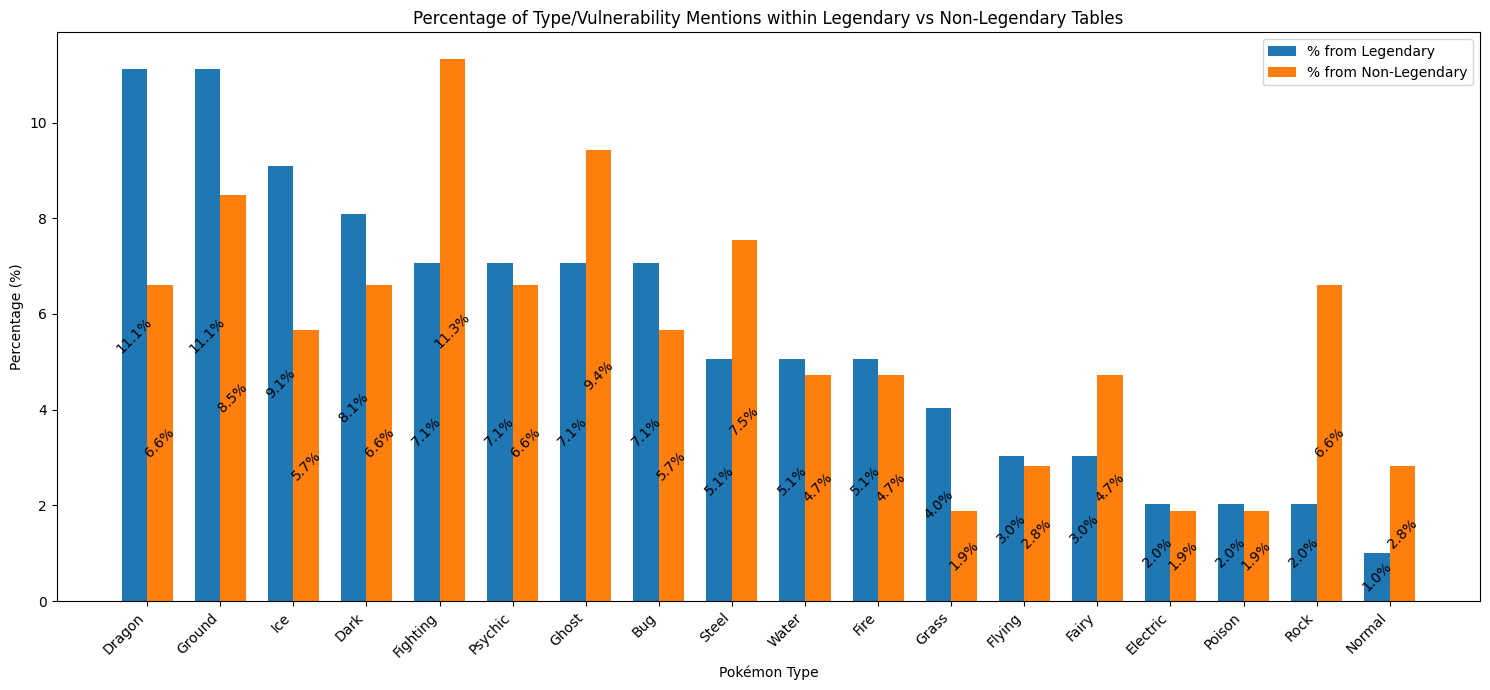

In [16]:
# Calculate Total Mentions (Legendary) for each type
type_mention_comparison['Legendary Total Mentions'] = type_mention_comparison['Legendary Tables Mentions'] + type_mention_comparison['Legendary Vulnerability Mentions']

# Calculate Total Mentions (Non-Legendary) for each type
type_mention_comparison['Non-Legendary Total Mentions'] = type_mention_comparison['Non-Legendary Tables Mentions'] + type_mention_comparison['Non-Legendary Vulnerability Mentions']

# Calculate the overall total mentions for each type across both legendary and non-legendary tables
type_mention_comparison['Overall Total Mentions'] = type_mention_comparison['Legendary Total Mentions'] + type_mention_comparison['Non-Legendary Total Mentions']

# Calculate the total mentions across ALL types in legendary tables
total_legendary_mentions_all_types = type_mention_comparison['Legendary Total Mentions'].sum()

# Calculate the total mentions across ALL types in non-legendary tables
total_non_legendary_mentions_all_types = type_mention_comparison['Non-Legendary Total Mentions'].sum()

# Calculate Percentage from Legendary based on the total legendary mentions across all types (avoid division by zero)
type_mention_comparison['% from Legendary'] = (type_mention_comparison['Legendary Total Mentions'] / total_legendary_mentions_all_types).fillna(0) * 100

# Calculate Percentage from Non-Legendary based on the total non-legendary mentions across all types (avoid division by zero)
type_mention_comparison['% from Non-Legendary'] = (type_mention_comparison['Non-Legendary Total Mentions'] / total_non_legendary_mentions_all_types).fillna(0) * 100


# Sort by the percentage from legendary in descending order (or you can choose a different sorting)
type_mention_comparison = type_mention_comparison.sort_values(by='% from Legendary', ascending=False)


# Plot the legendary and non-legendary percentages side-by-side
plt.figure(figsize=(15, 7))
bar_width = 0.35
index = range(len(type_mention_comparison.index))

bars1 = plt.bar(index, type_mention_comparison['% from Legendary'], bar_width, label='% from Legendary')
bars2 = plt.bar([i + bar_width for i in index], type_mention_comparison['% from Non-Legendary'], bar_width, label='% from Non-Legendary')

plt.title('Percentage of Type/Vulnerability Mentions within Legendary vs Non-Legendary Tables')
plt.xlabel('Pokémon Type')
plt.ylabel('Percentage (%)')
plt.xticks([i + bar_width / 2 for i in index], type_mention_comparison.index, rotation=45, ha='right')
plt.legend()

# Add percentage labels on top of bars (optional, can be crowded)
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.1f}%', ha='center', va='center', rotation=45) # Adjust vertical position and add rotation

plt.tight_layout()
plt.show()

### Conclusion 2: Legendary Pokémon's Impact on Type Stats

Our analysis reveals that Legendary Pokémon have a significant impact on raw stats, the perception of the strongest types, and the overall fighting meta. The comparison of type and vulnerability mentions in the top Pokémon lists clearly shows a substantial shift when Legendary Pokémon are included versus when they are removed.

This indicates that while some types consistently perform well regardless of Legendary Pokémon, the presence of Legendaries can significantly elevate the prominence of certain types in top-tier competitive play due to their exceptional raw stats and unique type combinations and vulnerabilities. The data suggests that the meta game is indeed influenced by these powerful Pokémon, altering which types are most frequently seen among the strongest contenders.

### Analysis 3: Generational Shifts and Type Dominance
Building upon our understanding of how individual Pokémon, including Legendaries, shape type statistics (Analysis 2), this section examines the broader impact of introducing new Pokémon across different game generations.

Question: How has the introduction of new Pokémon in each generation influenced the relative strength and ranking of different types over time?

We will analyze how the average stats and overall dominance of Pokémon types have evolved with each new game release, observing any trends or significant shifts in the competitive landscape.

In [17]:
# Get all unique values from the 'Game(s) of Origin' column
unique_games = dfpok['Game(s) of Origin'].unique()

# Display the unique values as a list, one per line
for game in unique_games.tolist():
    print(game)

Red
X
Sword
Omega Ruby
Sun
Let's Go Pikachu
Legends Arceus
Scarlet
Gold
Ruby
Fire Red
Leaf Green
Emerald
Diamond
Platinum
Black
Black 2
Ultra Sun
Pokémon GO
Violet


Using each game's release as a timestamp, this analysis examines how the introduction of new Pokémon altered the competitive landscape.

In [18]:
# Create a dictionary mapping game titles to their specific release dates
# This information would typically be obtained from external sources.
game_release_dates = {
    'Red': '1996-02-27',
    'Gold': '1999-11-21',
    'Ruby': '2002-11-21',
    'Fire Red': '2004-01-29',
    'Leaf Green': '2004-01-29',
    'Emerald': '2004-09-16',
    'Diamond': '2006-09-28',
    'Platinum': '2008-09-13',
    'Black': '2010-09-18',
    'Black 2': '2012-06-23',
    'X': '2013-10-12',
    'Omega Ruby': '2014-11-21',
    'Sun': '2016-11-18',
    'Pokémon GO': '2016-07-06', # Note: Added Pokémon GO as it was in your unique list
    'Ultra Sun': '2017-11-17',
    "Let's Go Pikachu": '2018-11-16',
    'Sword': '2019-11-15',
    'Legends Arceus': '2022-01-28',
    'Scarlet': '2022-11-18',
    'Violet': '2022-11-18'
}

# Create a DataFrame from the dictionary
df_game_release = pd.DataFrame(list(game_release_dates.items()), columns=['Game', 'Release Date'])

# Convert 'Release Date' to datetime objects
df_game_release['Release Date'] = pd.to_datetime(df_game_release['Release Date'])

# Sort the DataFrame by 'Release Date'
df_game_release = df_game_release.sort_values(by='Release Date').reset_index(drop=True)

# Display the new DataFrame
display(df_game_release)

,Game,Release Date
0,Red,1996-02-27
1,Gold,1999-11-21
2,Ruby,2002-11-21
3,Fire Red,2004-01-29
4,Leaf Green,2004-01-29
5,Emerald,2004-09-16
6,Diamond,2006-09-28
7,Platinum,2008-09-13
8,Black,2010-09-18
9,Black 2,2012-06-23


In [19]:
# Create a mapping from game title to release date using df_game_release
game_date_mapping = df_game_release.set_index('Game')['Release Date']

# Map the release dates to the dfstrong DataFrame based on 'Game(s) of Origin'
dfstrong['Release Date'] = dfstrong['Game(s) of Origin'].map(game_date_mapping)

# Convert the 'Release Date' column to datetime objects (if it's not already)
dfstrong['Release Date'] = pd.to_datetime(dfstrong['Release Date'])
dfstrong

,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,...,von_Bug,von_Rock,von_Ghost,von_Dragon,von_Dark,von_Steel,von_Fairy,Effective Health,Effective Special Health,Release Date
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.00,1.0,1.0,1.0,1.0,1.0,0.5,163,180,1996-02-27
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,...,1.00,1.0,1.0,1.0,1.0,1.0,0.5,203,200,2013-10-12
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,...,1.00,1.0,1.0,1.0,1.0,1.0,0.5,163,180,2019-11-15
7,7,6,Charizard,Flame Pokémon,NaN,<NA>,NaN,Fire,Flying,Red,...,0.25,4.0,1.0,1.0,1.0,0.5,0.5,156,163,1996-02-27
8,8,6,Charizard,Flame Pokémon,Mega X,7,NaN,Fire,Dragon,X,...,0.50,2.0,1.0,2.0,1.0,0.5,1.0,189,163,2013-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1873,1023,Iron Crown,Paradox Pokémon,NaN,<NA>,NaN,Steel,Psychic,Scarlet,...,1.00,0.5,2.0,0.5,2.0,0.5,0.5,190,198,2022-11-18
1378,1882,1024,Terapagos,Tera Pokémon,Stellar,1769,Legendary,Normal,NaN,Violet,...,1.00,1.0,0.0,1.0,1.0,1.0,1.0,270,270,2022-11-18
1379,1769,1024,Terapagos,Tera Pokémon,NaN,<NA>,Legendary,Normal,NaN,Violet,...,1.00,1.0,0.0,1.0,1.0,1.0,1.0,175,175,2022-11-18
1380,1770,1024,Terapagos,Tera Pokémon,Terastal,1769,Legendary,Normal,NaN,Scarlet,...,1.00,1.0,0.0,1.0,1.0,1.0,1.0,205,205,2022-11-18


In [20]:
# Get unique sorted release dates
unique_release_dates = sorted(dfstrong['Release Date'].dropna().unique())

# Dictionary to store results for each release date
results_by_release_date = {}

# Calculate the average of the top N for specific stats across primary or secondary type
def top_n_avg(df, stat, n=10):
    # Calculate the number of top Pokemon to take (at most n, and at most the size of the DataFrame)
    top_n = min(n, len(df))
    if top_n == 0:
        return None
    # Sort by the stat in descending order and take the top_n
    top_df = df.sort_values(by=stat, ascending=False).head(top_n)
    # Calculate the average of the stat for the top Pokemon
    return top_df[stat].mean()


# Iterate through release dates
for release_date in unique_release_dates:
    # Filter DataFrame by release date
    df_filtered = dfstrong[dfstrong['Release Date'] <= release_date].copy()

    if not df_filtered.empty:
        # Get all unique types present in the filtered data
        all_types_filtered = pd.concat([df_filtered['Primary Type'], df_filtered['Secondary Type']]).dropna().unique()

        # Create a dictionary to store the average of the top 10 Pokemon for each stat and type
        top_stats_by_type_filtered = {}
        stats_to_analyze = ['Attack Stat', 'Special Attack Stat', 'Effective Health', 'Effective Special Health', 'Base Stat Total']

        # Iterate over each unique type in the filtered data
        for pokemon_type in all_types_filtered:
            # Filter for Pokemon that have the current type in either Primary or Secondary Type
            type_df_filtered = df_filtered[(df_filtered['Primary Type'] == pokemon_type) | (df_filtered['Secondary Type'] == pokemon_type)].copy()

            top_stats_by_type_filtered[pokemon_type] = {}
            for stat in stats_to_analyze:
                if not type_df_filtered.empty:
                     top_stats_by_type_filtered[pokemon_type][stat] = top_n_avg(type_df_filtered, stat, n=10)
                else:
                     top_stats_by_type_filtered[pokemon_type][stat] = None

        # Convert the dictionary to a DataFrame
        top_stats_df_filtered = pd.DataFrame.from_dict(top_stats_by_type_filtered, orient='index')

        # Create a DataFrame to hold the top 5 types for each stat category
        results_df = pd.DataFrame(index=range(1, 6)) # Index 1 to 5

        # Populate the results_df with the top 5 types for each stat category
        for stat in stats_to_analyze:
            if stat in top_stats_df_filtered.columns:
                # Sort by the stat and get the top 5 type names
                top_5_types_for_stat = top_stats_df_filtered.sort_values(by=stat, ascending=False).head(5).index.tolist()
                # Pad with None if less than 5 types
                while len(top_5_types_for_stat) < 5:
                    top_5_types_for_stat.append(None)
                results_df[stat.replace(' Stat', '')] = top_5_types_for_stat # Remove " Stat"

        # Store results
        results_by_release_date[release_date.strftime('%Y-%m-%d')] = results_df


# Display results for each release date
for date, results_df in results_by_release_date.items():
    display(f"Top 5 Strongest Types by Stat (based on average of top 10 stats) (until {date}):")
    display(results_df.fillna('-')) # Display the ranked types table

'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 1996-02-27):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Dragon,Ghost,Water,Dragon,Dragon
2,Fighting,Psychic,Dragon,Water,Fire
3,Flying,Electric,Ice,Fairy,Flying
4,Fire,Dragon,Rock,Ice,Psychic
5,Rock,Grass,Ground,Psychic,Electric


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 1999-11-21):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Dragon,Ghost,Steel,Flying,Flying
2,Fighting,Psychic,Water,Water,Dragon
3,Flying,Flying,Psychic,Psychic,Psychic
4,Water,Fire,Rock,Normal,Fire
5,Fire,Electric,Flying,Dark,Dark


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2002-11-21):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Flying,Psychic,Rock,Water,Psychic
2,Water,Flying,Steel,Normal,Flying
3,Rock,Water,Water,Psychic,Dragon
4,Fighting,Fire,Psychic,Flying,Water
5,Ground,Dragon,Ground,Dragon,Fire


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2004-01-29):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Flying,Psychic,Rock,Water,Psychic
2,Psychic,Flying,Steel,Psychic,Flying
3,Water,Water,Psychic,Normal,Dragon
4,Rock,Fire,Water,Flying,Water
5,Fighting,Dragon,Ground,Dragon,Fire


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2004-09-16):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Flying,Psychic,Rock,Water,Psychic
2,Psychic,Flying,Steel,Psychic,Flying
3,Water,Water,Psychic,Normal,Dragon
4,Rock,Fire,Water,Flying,Water
5,Fighting,Dragon,Ground,Dragon,Fire


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2006-09-28):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Flying,Psychic,Rock,Normal,Dragon
2,Psychic,Dragon,Steel,Water,Psychic
3,Rock,Flying,Ground,Psychic,Flying
4,Ground,Water,Normal,Flying,Water
5,Fighting,Fire,Psychic,Dragon,Steel


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2008-09-13):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Flying,Psychic,Rock,Normal,Dragon
2,Psychic,Dragon,Steel,Water,Psychic
3,Rock,Flying,Ground,Psychic,Flying
4,Ground,Water,Normal,Flying,Water
5,Dragon,Fire,Psychic,Dragon,Steel


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2010-09-18):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Dragon,Psychic,Rock,Normal,Dragon
2,Rock,Dragon,Steel,Psychic,Flying
3,Flying,Fire,Ground,Water,Psychic
4,Ground,Flying,Normal,Dragon,Fire
5,Fighting,Water,Water,Flying,Normal


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2012-06-23):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Dragon,Psychic,Rock,Normal,Dragon
2,Flying,Dragon,Steel,Psychic,Flying
3,Ground,Fire,Dragon,Dragon,Psychic
4,Rock,Flying,Ground,Water,Fire
5,Fighting,Water,Normal,Flying,Normal


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2013-10-12):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Dragon,Psychic,Rock,Normal,Dragon
2,Fighting,Dragon,Steel,Dragon,Psychic
3,Rock,Fire,Dragon,Psychic,Flying
4,Psychic,Flying,Ground,Fairy,Fire
5,Flying,Electric,Normal,Water,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2014-11-21):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Steel,Normal,Dragon
2,Dragon,Dragon,Ground,Dragon,Psychic
3,Ground,Fire,Rock,Psychic,Flying
4,Flying,Flying,Dragon,Water,Fire
5,Fighting,Water,Psychic,Fairy,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2016-07-06):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Steel,Normal,Dragon
2,Dragon,Dragon,Ground,Dragon,Psychic
3,Ground,Fire,Rock,Psychic,Flying
4,Flying,Flying,Dragon,Water,Fire
5,Fighting,Water,Psychic,Fairy,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2016-11-18):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Steel,Dragon,Psychic
2,Dragon,Dragon,Ground,Normal,Dragon
3,Fighting,Water,Dragon,Psychic,Flying
4,Ground,Fire,Rock,Water,Ground
5,Steel,Flying,Psychic,Fairy,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2017-11-17):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Steel,Dragon,Psychic
2,Dragon,Dragon,Ground,Normal,Dragon
3,Steel,Fire,Dragon,Psychic,Flying
4,Fighting,Water,Rock,Water,Ground
5,Ground,Ghost,Psychic,Fairy,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2018-11-16):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Steel,Dragon,Psychic
2,Dragon,Dragon,Ground,Normal,Dragon
3,Steel,Fire,Dragon,Psychic,Flying
4,Fighting,Water,Rock,Water,Ground
5,Ground,Ghost,Psychic,Fairy,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2019-11-15):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Dragon,Dragon,Dragon
2,Dragon,Dragon,Steel,Normal,Psychic
3,Steel,Ghost,Ground,Poison,Flying
4,Fighting,Fire,Rock,Psychic,Steel
5,Ground,Water,Psychic,Water,Ground


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2022-01-28):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Dragon,Dragon,Dragon
2,Dragon,Dragon,Steel,Normal,Psychic
3,Steel,Ghost,Ground,Poison,Steel
4,Fighting,Water,Rock,Psychic,Flying
5,Ground,Fire,Psychic,Water,Water


'Top 5 Strongest Types by Stat (based on average of top 10 stats) (until 2022-11-18):'

,Attack,Special Attack,Effective Health,Effective Special Health,Base Total
1,Psychic,Psychic,Dragon,Dragon,Dragon
2,Dragon,Dragon,Steel,Normal,Psychic
3,Steel,Ghost,Ground,Poison,Steel
4,Fighting,Fire,Rock,Psychic,Flying
5,Ground,Water,Normal,Fairy,Water


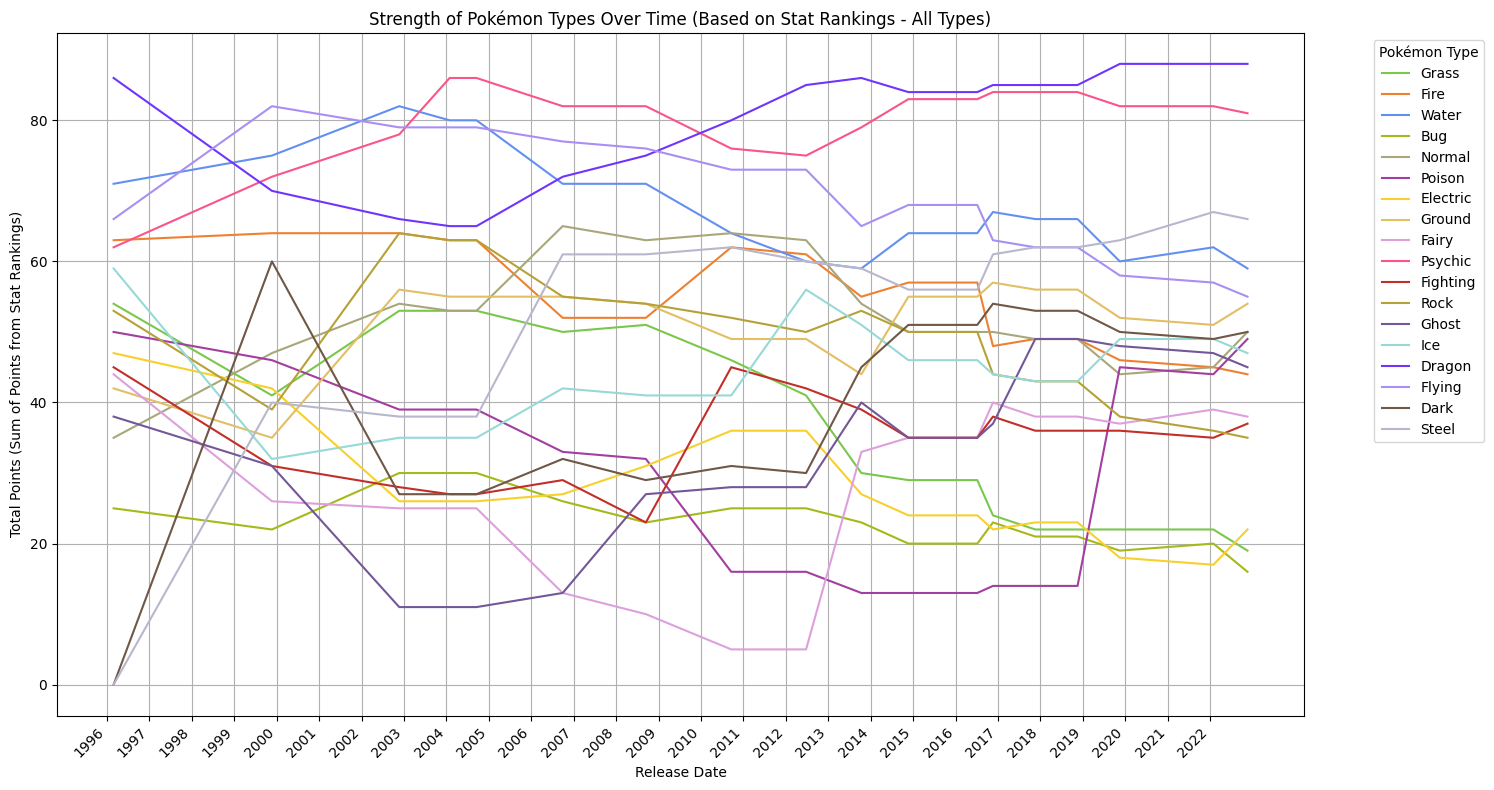

In [21]:
# Dictionary to store points per type per release date
points_by_release_date = {}

# Total number of Pokémon types
total_pokemon_types = 18

# Define a dictionary for standard Pokémon type colors (hex codes)
pokemon_type_colors = {
    'Normal': '#A8A77A',
    'Fire': '#EE8130',
    'Water': '#6390F0',
    'Electric': '#F7D02C',
    'Grass': '#7AC74C',
    'Ice': '#96D9D6',
    'Fighting': '#C22E28',
    'Poison': '#A33EA1',
    'Ground': '#E2BF65',
    'Flying': '#A98FF3',
    'Psychic': '#F95587',
    'Bug': '#A6B91A',
    'Rock': '#B6A136',
    'Ghost': '#735797',
    'Dragon': '#6F35FC',
    'Dark': '#705746',
    'Steel': '#B7B7CE',
    'Fairy': '#DDA0DD',
}


# Process the ranking data from results_by_release_date
for date_str, ranked_types_df in results_by_release_date.items():
    release_date = pd.to_datetime(date_str)

    # Dictionary to store points for each type for the current release date
    points_for_date = {}

    # Filter DataFrame by release date
    df_filtered = dfstrong[dfstrong['Release Date'] <= release_date].copy()

    if not df_filtered.empty:
        # Get all unique types present in the filtered data
        all_types_filtered = pd.concat([df_filtered['Primary Type'], df_filtered['Secondary Type']]).dropna().unique()

        # Create a dictionary to store the average of the top 10 Pokemon for each stat and type
        top_stats_by_type_filtered = {}
        stats_to_analyze = ['Attack Stat', 'Special Attack Stat', 'Effective Health', 'Effective Special Health', 'Base Stat Total']

        for pokemon_type in all_types_filtered:
            type_df_filtered = df_filtered[(df_filtered['Primary Type'] == pokemon_type) | (df_filtered['Secondary Type'] == pokemon_type)].copy()
            top_stats_by_type_filtered[pokemon_type] = {}
            for stat in stats_to_analyze:
                if not type_df_filtered.empty:
                     top_stats_by_type_filtered[pokemon_type][stat] = top_n_avg(type_df_filtered, stat, n=10)
                else:
                     top_stats_by_type_filtered[pokemon_type][stat] = None

        top_stats_df_filtered = pd.DataFrame.from_dict(top_stats_by_type_filtered, orient='index')

        # Rank *all* types by average stats for this release date
        ranked_types_for_points = {}
        for stat in stats_to_analyze:
            if stat in top_stats_df_filtered.columns:
                # Sort by the stat and get all type names
                all_ranked_types_for_stat = top_stats_df_filtered.sort_values(by=stat, ascending=False).index.tolist()
                ranked_types_for_points[stat] = all_ranked_types_for_stat

        # Calculate points based on rank among all types using a fixed scale of 1 to 18
        all_types_present = all_types_filtered.tolist()

        for type_name in all_types_present:
            total_points = 0
            for stat in stats_to_analyze:
                stat_ranked_list = ranked_types_for_points.get(stat, [])
                if type_name in stat_ranked_list:
                    # Rank is 1-based index + 1
                    rank = stat_ranked_list.index(type_name) + 1
                    # Points: Rank 1 gets 18 points, Rank 18 gets 1 point
                    # Points = total_pokemon_types - rank + 1
                    total_points += (total_pokemon_types - rank + 1)


            if num_stats > 0: # Avoid division by zero if no stats analyzed
                 points_for_date[type_name] = total_points # Sum of points from each stat

    # Store the points for the current release date using the date_str as the key
    points_by_release_date[date_str] = points_for_date


# Convert the points data to a DataFrame for time series plotting
# Create a list of dictionaries, one for each release date
time_series_data = []
for date_str, points_data in points_by_release_date.items():
    row_data = {'Release Date': pd.to_datetime(date_str)}
    row_data.update(points_data)
    time_series_data.append(row_data)

df_time_series = pd.DataFrame(time_series_data)

# Set 'Release Date' as the index and sort by date
df_time_series = df_time_series.set_index('Release Date').sort_index()

df_time_series = df_time_series.fillna(0) # Keeping fillna(0) as per previous versions, but be mindful of interpretation

# Plot the time series
plt.figure(figsize=(15, 8))

# Use a smoother line style and keep markers, using custom colors
for column in df_time_series.columns:
    color = pokemon_type_colors.get(column, '#000000') # Default to black if color not found
    plt.plot(df_time_series.index, df_time_series[column], marker="", linestyle='-', label=column, color=color)


plt.title('Strength of Pokémon Types Over Time (Based on Stat Rankings - All Types)')
plt.xlabel('Release Date')
plt.ylabel('Total Points (Sum of Points from Stat Rankings)')
plt.grid(True)
plt.legend(title='Pokémon Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis ticks to show all years from the first to the last release date
if not df_time_series.empty:
    min_year = df_time_series.index.min().year
    max_year = df_time_series.index.max().year
    all_years = range(min_year, max_year + 1)
    plt.xticks([pd.to_datetime(f'{year}-01-01') for year in all_years], all_years, rotation=45, ha='right')


plt.tight_layout()
plt.show()

### Conclusion 3:  Generational Shifts and Type Dominance

The introduction of new Pokémon with each game release leads to shifts in which types rank among the strongest for various stats over the years. However, some types consistently maintain high rankings in specific stat categories, likely due to the inherent design philosophy for those types (e.g., being intended as heavy hitters or defensive powerhouses).

As more Pokémon are introduced, significantly altering the dominance of existing top types becomes increasingly challenging without potentially making older Pokémon obsolete. This might explain why the shifts in top types appear less dramatic in later tables compared to the earlier ones.

It's also important to note that the introduction of entirely new Pokémon types, which weren't present in earlier games, has a significant impact on the competitive landscape and the meta.

Finally, this analysis focuses on raw stats and type effectiveness. Factors like Abilities, hidden abilities, and unique moves, which are less quantifiable in this table format, also play a crucial role in a Pokémon's strength and the overall game meta.

### Analysis 4: Forecasting Future Type Dominance Through Game Design Trends
Building on our analysis of type strength and generational shifts (Analyses 1-3), we now aim to forecast future trends.

Question: Using game release dates as a historical marker, can we forecast which Pokémon types are likely to see changes in their average statistical profiles in the next generation, based on observed game design trends?

To predict future Pokémon type and stat trends, I'm focusing on aggregated type data. I'll calculate the average stats for each type, including their strengths and weaknesses based on type matchups, assuming Pokémon only use attacks matching their type (STAB). I'm using game release dates as my timeline to capture how the overall game meta has evolved, but this analysis doesn't include abilities, hidden abilities, status effects, or specific in-game attacks and items.

In [22]:
# Map the release dates to the dfpok DataFrame based on 'Game(s) of Origin'
dfpok['Release Date'] = dfpok['Game(s) of Origin'].map(game_date_mapping)

# Convert the 'Release Date' column to datetime objects (if it's not already)
dfpok['Release Date'] = pd.to_datetime(dfpok['Release Date'])

# Get unique sorted release dates - these will be our time points
unique_release_dates = sorted(dfpok['Release Date'].dropna().unique())

# List of stats to aggregate for each type
stats_to_aggregate = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total']

# Get list of vulnerability columns (e.g., 'von_Normal', 'von_Fire')
vulnerability_cols = [col for col in dfpok.columns if col.startswith('von_')]

# List to store aggregated data for each release date
aggregated_time_series_data = []

# Loop through each unique release date to build the time series data
for release_date in unique_release_dates:
    # Include all Pokémon released up to this date for cumulative analysis
    df_cumulative = dfpok[dfpok['Release Date'] <= release_date].copy()

    if not df_cumulative.empty:
        # Find all unique types present in the data up to this release date
        all_types_cumulative = pd.concat([df_cumulative['Primary Type'], df_cumulative['Secondary Type']]).dropna().unique()

        # Dictionary to hold aggregated data for the current date
        aggregated_data_for_date = {'Release Date': release_date}

        # Calculate average stats and vulnerabilities for each type
        for pokemon_type in all_types_cumulative:
            # Filter for Pokémon that are of the current type (primary or secondary)
            type_df_cumulative = df_cumulative[(df_cumulative['Primary Type'] == pokemon_type) | (df_cumulative['Secondary Type'] == pokemon_type)].copy()

            if not type_df_cumulative.empty:
                # Calculate and store average stats for this type at this date
                for stat in stats_to_aggregate:
                    aggregated_data_for_date[f'{pokemon_type}_Avg_{stat.replace(" Stat", "")}'] = type_df_cumulative[stat].mean()

                # Calculate and store average vulnerability to each attacking type
                for von_col in vulnerability_cols:
                    attacking_type = von_col.replace('von_', '')
                    aggregated_data_for_date[f'{pokemon_type}_Avg_{von_col}'] = type_df_cumulative[von_col].mean()

        # Add the aggregated data for this date to our list
        aggregated_time_series_data.append(aggregated_data_for_date)

# Convert the list of data dictionaries into a DataFrame
df_time_series_aggregated = pd.DataFrame(aggregated_time_series_data)

# Set Release Date as the index and sort
df_time_series_aggregated = df_time_series_aggregated.set_index('Release Date').sort_index()

# Remove any rows that might have resulted in NaNs (e.g., types not present until later generations)
df_time_series_aggregated = df_time_series_aggregated.dropna()


# Display the first few rows of the aggregated time series data
display(df_time_series_aggregated.head())

,Grass_Avg_Health,Grass_Avg_Attack,Grass_Avg_Defense,Grass_Avg_Special Attack,Grass_Avg_Special Defense,Grass_Avg_Speed,Grass_Avg_Base Total,Grass_Avg_von_Normal,Grass_Avg_von_Fire,Grass_Avg_von_Water,...,Dark_Avg_von_Ground,Dark_Avg_von_Flying,Dark_Avg_von_Psychic,Dark_Avg_von_Bug,Dark_Avg_von_Rock,Dark_Avg_von_Ghost,Dark_Avg_von_Dragon,Dark_Avg_von_Dark,Dark_Avg_von_Steel,Dark_Avg_von_Fairy
Release Date,,,,,,,,,,,,,,,,,,,,,
1999-11-21,62.708333,67.750000,68.958333,75.625000,70.416667,54.791667,400.250000,1.000000,2.166667,0.500000,...,1.333333,0.916667,0.0,1.500000,1.666667,0.500000,1.0,0.500000,1.166667,1.666667
2002-11-21,63.073171,68.317073,64.439024,74.487805,68.926829,56.024390,395.268293,0.975610,1.975610,0.506098,...,1.031250,1.156250,0.0,2.125000,1.250000,0.531250,1.0,0.531250,0.968750,1.875000
2004-01-29,63.073171,68.317073,64.439024,74.487805,68.926829,56.024390,395.268293,0.975610,1.975610,0.506098,...,1.031250,1.156250,0.0,2.125000,1.250000,0.531250,1.0,0.531250,0.968750,1.875000
2004-09-16,63.073171,68.317073,64.439024,74.487805,68.926829,56.024390,395.268293,0.975610,1.975610,0.506098,...,1.031250,1.156250,0.0,2.125000,1.250000,0.531250,1.0,0.531250,0.968750,1.875000
2006-09-28,65.000000,70.636364,68.145455,75.381818,70.436364,56.581818,406.181818,0.981818,2.090909,0.513636,...,1.108696,1.108696,0.0,1.869565,1.260870,0.543478,1.0,0.543478,1.021739,1.782609


Choosing a Multivariate time series model because it allows me to simultaneously analyze and model the relationships between the time series of different Pokémon types. Given that changes in the design and balance of one type often influence the relative strength and role of others within the evolving game meta, a multivariate approach is best equipped to capture these complex, co-varying dynamics over time, leading to more robust forecasts than analyzing each type in isolation.

In [23]:
# Prepare the data for modeling
# We'll use a simple numerical index based on the sequence of release dates
first_release_date = df_time_series_aggregated.index.min()
time_index_numeric_all = (df_time_series_aggregated.index - first_release_date).days.values.reshape(-1, 1)

# Fill any remaining NaN values with 0 for the model (simplification)
df_time_series_aggregated_filled = df_time_series_aggregated.fillna(0)

# Dictionary to store the MSE scores for each prediction step
scores_by_prediction_step = {}

# Define the starting index for our time-based cross-validation
# We need enough previous data points to train the model
start_index_evaluation = 4 # Starting from the 5th release date (index 4)

if len(df_time_series_aggregated_filled) < start_index_evaluation + 1:
    print("Not enough data points to perform time-based cross-validation with the specified starting point.")
else:
    # Suppress a specific warning about empty slices that can occur with NaNs
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    # Iterate through the release dates to perform cross-validation
    for i in range(start_index_evaluation, len(df_time_series_aggregated_filled)):
        # Training data includes all releases up to the current one
        train_time_numeric = time_index_numeric_all[:i]
        train_data = df_time_series_aggregated_filled.iloc[:i]

        # Testing data is the next single release date
        test_time_numeric = time_index_numeric_all[i:i+1]
        test_data = df_time_series_aggregated_filled.iloc[i:i+1]

        if not test_data.empty:
            # Get the date for this prediction step
            prediction_date = df_time_series_aggregated_filled.index[i].strftime('%Y-%m-%d')

            # Dictionary to store MSE scores for this specific prediction date
            scores_this_step = {}

            # Iterate through each aggregated metric (each column)
            for column in train_data.columns:
                y_train = train_data[column].values
                y_test = test_data[column].values

                # Create and train the polynomial regression model (degree 2)
                polynomial_degree = 2
                model = make_pipeline(PolynomialFeatures(degree=polynomial_degree), LinearRegression())
                model.fit(train_time_numeric, y_train)

                # Make a prediction for the next time point
                prediction = model.predict(test_time_numeric)[0]
                actual_value = y_test[0]

                # Calculate the Mean Squared Error (MSE) for this prediction
                mse = mean_squared_error([actual_value], [prediction])

                # Store the calculated MSE
                scores_this_step[column] = mse

            # Store the scores for this prediction date
            scores_by_prediction_step[prediction_date] = scores_this_step

    # --- Restructure and Display Results ---
    print("\nMean Squared Error (MSE) for each aggregated metric at each prediction step:")

    # Convert the nested dictionary of scores into a DataFrame for easy viewing
    # Transpose so metrics are rows and dates are columns
    df_mse_by_prediction_step = pd.DataFrame.from_dict(scores_by_prediction_step, orient='index').T

    # Display the MSE DataFrame, rounded for readability
    display(df_mse_by_prediction_step.round(2))


Mean Squared Error (MSE) for each aggregated metric at each prediction step:


,2006-09-28,2008-09-13,2010-09-18,2012-06-23,2013-10-12,2014-11-21,2016-07-06,2016-11-18,2017-11-17,2018-11-16,2019-11-15,2022-01-28,2022-11-18
Grass_Avg_Health,4.53,2.47,2.38,1.56,0.02,0.11,0.28,0.36,0.20,0.09,2.33,0.50,0.09
Grass_Avg_Attack,6.94,3.20,5.17,1.85,3.20,0.28,0.54,1.05,0.00,0.48,0.16,1.92,0.12
Grass_Avg_Defense,1.43,27.51,35.08,20.44,0.13,2.22,9.95,1.79,3.85,5.07,1.77,8.52,4.64
Grass_Avg_Special Attack,0.07,0.03,47.76,0.33,0.08,2.58,4.14,0.92,1.16,1.17,1.26,1.49,3.44
Grass_Avg_Special Defense,0.46,2.51,8.46,3.43,1.28,0.43,0.49,0.13,0.12,0.10,0.01,0.00,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dark_Avg_von_Ghost,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dark_Avg_von_Dragon,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
Dark_Avg_von_Dark,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dark_Avg_von_Steel,0.00,0.02,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [24]:
# Assuming df_time_series_aggregated was created in a previous cell (e.g., 13317a3e)
if 'df_time_series_aggregated' not in locals():
    print("Error: df_time_series_aggregated DataFrame not found. Please run the data aggregation cell first.")
else:
    # Prepare the data for modeling - Use a simple integer index representing the sequence of releases
    # This index will be 0, 1, 2, ... corresponding to the order of releases
    time_index_numeric_all = np.arange(len(df_time_series_aggregated)).reshape(-1, 1)

    # Fill NaN values with 0 for training the final model (simplification)
    df_time_series_aggregated_filled = df_time_series_aggregated.fillna(0)

    # --- Train the final Polynomial Regression Model (Degree 2) on the entire dataset ---

    print("Training final Polynomial Regression Model (Degree 2) on the entire dataset using sequence index...")

    # Dictionary to store the trained models for each metric
    final_fitted_models = {}

    # Define the polynomial degree we chose
    chosen_polynomial_degree = 2

    # Iterate through each column (time series) in the aggregated DataFrame
    for column in df_time_series_aggregated_filled.columns:
        # Get the historical values for this metric
        y = df_time_series_aggregated_filled[column].values

        # Create and fit the polynomial regression model
        model = make_pipeline(PolynomialFeatures(degree=chosen_polynomial_degree), LinearRegression())

        # Train the model on all historical data using the integer index
        model.fit(time_index_numeric_all, y)

        # Store the trained model
        final_fitted_models[column] = model

    print(f"Final Polynomial Regression Models (Degree {chosen_polynomial_degree}) fitted for each time series.")

    # Define the numerical index for the *next* release date we want to forecast
    # It's simply the total number of historical releases
    future_step_numeric = np.array([len(df_time_series_aggregated)]).reshape(-1, 1)

    # Dictionary to store the forecasted values
    forecasted_values = {}

    # Use each trained model to predict the value for the next release
    for column, model in final_fitted_models.items():
        forecasted_value = model.predict(future_step_numeric)[0]
        # We could add checks here, e.g., to ensure stats aren't negative if they should be
        # forecasted_value = max(0, forecasted_value) # Example: Clamp at 0
        forecasted_values[column] = forecasted_value

    # Convert the forecasted values into a pandas Series for easier viewing
    df_forecasted_values = pd.Series(forecasted_values)

    # Display the forecasted values
    display(f"\nForecasted aggregated metrics for the Next Release (based on sequence):")
    display(df_forecasted_values)

Training final Polynomial Regression Model (Degree 2) on the entire dataset using sequence index...
Final Polynomial Regression Models (Degree 2) fitted for each time series.


'\nForecasted aggregated metrics for the Next Release (based on sequence):'

,0
Grass_Avg_Health,67.391480
Grass_Avg_Attack,78.344413
Grass_Avg_Defense,74.908227
Grass_Avg_Special Attack,71.904568
Grass_Avg_Special Defense,72.085143
...,...
Dark_Avg_von_Ghost,0.490043
Dark_Avg_von_Dragon,0.978579
Dark_Avg_von_Dark,0.502044
Dark_Avg_von_Steel,1.030373


Using our time series model, we have forecasted the average statistical profiles and type interaction dynamics for each Pokémon type in the anticipated next generation. While these aggregated forecasts do not directly predict the attributes of individual Pokémon, they provide valuable insights into the likely direction of change for each type's overall power level and matchup effectiveness. By analyzing the projected differences between the forecasted aggregated metrics and the observed metrics from the most recent generation, we can identify potential shifts in the competitive landscape and anticipate which Pokémon types are statistically poised to become more or less prominent in the evolving meta.

In [25]:
# Ensure df_forecasted_values and df_time_series_aggregated_filled are available
# Assuming df_forecasted_values was created in the previous cell (372ebda6)
# Assuming df_time_series_aggregated_filled was created in a previous cell (e.g., 13317a3e or 372ebda6)

if 'df_forecasted_values' not in locals() or 'df_time_series_aggregated_filled' not in locals():
    print("Error: Forecasted values or aggregated historical data not found. Please run the necessary cells first.")
else:
    # Get the actual aggregated values for the last release date in the historical data
    last_historical_aggregated_values = df_time_series_aggregated_filled.iloc[-1]

    # Calculate the delta (forecasted value - last historical value)
    df_predicted_delta = df_forecasted_values - last_historical_aggregated_values

    display("Predicted Change (Delta) in Aggregated Metrics for the Next Release:")
    display(df_predicted_delta.sort_values(ascending=False)) # Display sorted to see largest changes

'Predicted Change (Delta) in Aggregated Metrics for the Next Release:'

,0
Fairy_Avg_Base Total,26.199348
Poison_Avg_Base Total,6.505431
Bug_Avg_Base Total,6.372840
Fairy_Avg_Special Defense,6.231135
Psychic_Avg_Base Total,6.038470
...,...
Ghost_Avg_Health,-3.311023
Ghost_Avg_Defense,-3.438905
Ice_Avg_Base Total,-3.762398
Steel_Avg_Special Defense,-4.935533


In [32]:
# @title Default title text
# Ensure df_predicted_delta is available from the previous cell (9ff93c5d)

if 'df_predicted_delta' not in locals():
    print("Error: Predicted delta DataFrame not found. Please run the previous cell to calculate the delta.")
else:
    print("Analyzing the most significant predicted changes (Deltas) to infer potential Pokémon characteristics:\n")

    # Sort deltas to see the largest positive and negative changes
    df_predicted_delta_sorted = df_predicted_delta.sort_values(ascending=False)

    # Display the top N positive and negative deltas
    top_n = 15 # Display top 15 positive and negative changes

    print(f"Top {top_n} Aggregated Metrics with Largest Predicted Positive Changes:")
    display(df_predicted_delta_sorted.head(top_n))

    print(f"\nTop {top_n} Aggregated Metrics with Largest Predicted Negative Changes:")
    display(df_predicted_delta_sorted.tail(top_n))

    print("\nInterpretation Guidance for Designing Hypothetical Pokémon:")

    # Function to extract Type and Metric type (Stat or Von)
    def extract_type_and_metric_info(metric_name):
        parts = metric_name.split('_Avg_')
        pokemon_type = parts[0]
        metric_type = parts[1] if len(parts) > 1 else None
        return pokemon_type, metric_type

    # Analyze the top positive deltas
    print("\nAnalyzing Top Positive Deltas (Predicted Increases):")
    for metric_name, delta_value in df_predicted_delta_sorted.head(top_n).items():
        pokemon_type, metric_type = extract_type_and_metric_info(metric_name)
        if metric_type and metric_type.endswith('Stat'):
            stat_name = metric_type.replace(' Stat', '')
            print(f"- A large predicted increase in {pokemon_type}'s Average {stat_name} ({delta_value:.2f}) suggests new {pokemon_type}-type Pokémon might have high {stat_name} stats.")
        elif metric_type and metric_type.startswith('von_'):
            attacking_type = metric_type.replace('von_', '')
            print(f"- A large predicted increase in {pokemon_type}'s Average Vulnerability to {attacking_type} ({delta_value:.2f}) suggests new {pokemon_type}-type Pokémon might become weaker to {attacking_type} attacks (potentially through new dual typings).")
        else:
             print(f"- A large predicted increase in {metric_name} ({delta_value:.2f}) observed.") # Catch other potential metric types


    # Analyze the top negative deltas
    print("\nAnalyzing Top Negative Deltas (Predicted Decreases):")
    for metric_name, delta_value in df_predicted_delta_sorted.tail(top_n).items():
        pokemon_type, metric_type = extract_type_and_metric_info(metric_name)
        if metric_type and metric_type.endswith('Stat'):
            stat_name = metric_type.replace(' Stat', '')
            print(f"- A large predicted decrease in {pokemon_type}'s Average {stat_name} ({delta_value:.2f}) suggests new {pokemon_type}-type Pokémon might have lower {stat_name} stats on average.")
        elif metric_type and metric_type.startswith('von_'):
            attacking_type = metric_type.replace('von_', '')
            # A decrease in vulnerability means becoming *more resistant*
            print(f"- A large predicted decrease in {pokemon_type}'s Average Vulnerability to {attacking_type} ({delta_value:.2f}) suggests new {pokemon_type}-type Pokémon might become more resistant to {attacking_type} attacks (potentially through new dual typings or abilities - though abilities aren't in our model).")
        else:
             print(f"- A large predicted decrease in {metric_name} ({delta_value:.2f}) observed.") # Catch other potential metric types

    print("\nUse these insights to guide the design of your 6 hypothetical Pokémon, focusing on types and stats that show the most significant predicted shifts.")

Analyzing the most significant predicted changes (Deltas) to infer potential Pokémon characteristics:

Top 15 Aggregated Metrics with Largest Predicted Positive Changes:


,0
Fairy_Avg_Base Total,26.199348
Poison_Avg_Base Total,6.505431
Bug_Avg_Base Total,6.372840
Fairy_Avg_Special Defense,6.231135
Psychic_Avg_Base Total,6.038470
Fairy_Avg_Special Attack,6.014185
Ghost_Avg_Special Attack,5.832572
Fairy_Avg_Attack,5.555716
Steel_Avg_Attack,4.953266
Rock_Avg_Speed,4.783451



Top 15 Aggregated Metrics with Largest Predicted Negative Changes:


,0
Dragon_Avg_Attack,-1.566854
Fighting_Avg_Special Attack,-1.676882
Grass_Avg_Base Total,-1.695866
Dragon_Avg_Health,-1.753803
Grass_Avg_Speed,-1.939759
Ground_Avg_Health,-1.939900
Ice_Avg_Special Attack,-2.119102
Dragon_Avg_Speed,-2.300544
Ghost_Avg_Special Defense,-2.434994
Rock_Avg_Defense,-2.662255



Interpretation Guidance for Designing Hypothetical Pokémon:

Analyzing Top Positive Deltas (Predicted Increases):
- A large predicted increase in Fairy_Avg_Base Total (26.20) observed.
- A large predicted increase in Poison_Avg_Base Total (6.51) observed.
- A large predicted increase in Bug_Avg_Base Total (6.37) observed.
- A large predicted increase in Fairy_Avg_Special Defense (6.23) observed.
- A large predicted increase in Psychic_Avg_Base Total (6.04) observed.
- A large predicted increase in Fairy_Avg_Special Attack (6.01) observed.
- A large predicted increase in Ghost_Avg_Special Attack (5.83) observed.
- A large predicted increase in Fairy_Avg_Attack (5.56) observed.
- A large predicted increase in Steel_Avg_Attack (4.95) observed.
- A large predicted increase in Rock_Avg_Speed (4.78) observed.
- A large predicted increase in Ghost_Avg_Speed (4.76) observed.
- A large predicted increase in Dark_Avg_Base Total (4.54) observed.
- A large predicted increase in Rock_Avg_Base Tota

In [30]:
# Ensure the API key is configured
GOOGLE_API_KEY = None
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    if not GOOGLE_API_KEY:
        raise ValueError("Google API Key not found in Colab secrets.")
    genai.configure(api_key=GOOGLE_API_KEY)
except ValueError as e:
    print(f"API Key setup failed: {e}")
    print("Please set up your Google API Key in Colab secrets (key name: GOOGLE_API_KEY).")
    genai = None # Ensure genai is None if API key is missing


# Ensure df_predicted_delta is available from the previous analysis cell (038b78e9)
if 'df_predicted_delta' not in locals():
    print("Error: Predicted delta DataFrame not found. Please run the delta analysis cell (038b78e9) first.")
    df_predicted_delta = None # Set to None if data is missing


# Proceed only if API key is set up and data is available
if genai is not None and df_predicted_delta is not None:
    # Get the top N positive and negative deltas to include in the prompt
    top_n = 15 # Use the same number as in the analysis cell
    df_predicted_delta_sorted = df_predicted_delta.sort_values(ascending=False)
    top_positive_deltas = df_predicted_delta_sorted.head(top_n)
    top_negative_deltas = df_predicted_delta_sorted.tail(top_n)

    # Format the delta data to include in the prompt
    delta_data_str = "Predicted Positive Changes (Increases):\n"
    delta_data_str += top_positive_deltas.to_string() + "\n\n"
    delta_data_str += "Predicted Negative Changes (Decreases):\n"
    delta_data_str += top_negative_deltas.to_string() + "\n"

    # Using Gemini to make up Pokemons that would fit the overall meta change
    user_prompt = """
    Using the provided predicted changes in aggregated type stats (positive delta = increase, negative delta = decrease),
    please invent 6-10 Pokémon. Focus on types and stats showing the largest projected shifts.
    Suggest potential typings (including dual types) and stat distributions for these hypothetical Pokémon
     that would influence the overall aggregated stats of their type.
     State specific stats of each pokemon by number for Attack Stat, Defense Stat, Health Stat, Special Attack Stat, Special Defense Stat, and Speed Stat.
     Make 1-3 of them Legendery or Mythical, note what they are, and their lore for the mythical or legenderies(they should be connected to each other in the lore)

    ---

    Predicted Changes Data (Delta from Last Generation Average):
    """ + delta_data_str

    # Initialize the Generative Model
    gemini_model = None # Initialize model as None
    try:
        # Try initializing a generally available model
        print("\nAttempting to initialize the Generative Model...")
        # Using gemini-1.5-flash-latest which is more broadly available
        gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest')
        print("Model initialized successfully.")
    except Exception as e:
         print(f"Error initializing model: {e}")
         print("Please check your API key, model name, and model availability in your region.")


    if gemini_model: # Proceed only if the model was successfully initialized
        print("\nCalling the LLM to invent Pokémon based on predicted deltas...")
        try:
            response = gemini_model.generate_content(user_prompt)
            print("\n--- Suggested Pokémon Characteristics from LLM ---")
            print(response.text)
            print("\n-------------------------------------------------")
        except Exception as e:
            print(f"Error calling the LLM: {e}")
            print("An error occurred during the API call. Check prompt content or model limits.")
else:
    print("\nSkipping LLM call due to missing API key or data.")


Attempting to initialize the Generative Model...
Model initialized successfully.

Calling the LLM to invent Pokémon based on predicted deltas...

--- Suggested Pokémon Characteristics from LLM ---
Based on the provided data, several Pokémon can be designed to reflect the predicted type stat changes.  The largest positive changes are in Fairy, Poison, and Bug, while the most significant negative shifts are in Dragon, Ghost, and Ice.  I'll focus on these types, with some incorporating others where appropriate.

**1.  Faelight (Fairy/Flying)**

*   Lore: A common fairy in the forests.
*   Legendary/Mythical: No
*   Attack: 75
*   Defense: 60
*   HP: 90
*   Special Attack: 110
*   Special Defense: 95
*   Speed: 90
    *   Reflects the increases in Fairy Special Attack, Special Defense, and general Fairy type stats.  Flying is added for balance, given the high special stats.

**2.  Venomveil (Poison/Grass)**

*   Lore: A shy forest dweller that lives in the depths of the forest.
*   Legend

### Conclusion 4: Forecasting Future Type Dominance Through Game Design Trends

Based on my forecast for question 4, it looks like some interesting shifts might happen in the next generation. My model suggests that types like Fairy, Poison, and Bug could see their average stats increase, while Dragon, Ghost, and Ice might see a decrease. This tells me that the game designers might be aiming to adjust the balance of these types in the upcoming game, which could definitely impact the competitive scene.

### Analysis 5: Legendaries: Lore vs. Meta Influence?
Given our findings in Analysis 2 regarding the significant impact of Legendary Pokémon on overall stats, and our forecasting in Analysis 4, we now investigate their role in game design trends.

Question: Does excluding Legendary and Mythical Pokémon lead to a better-performing forecasting model, suggesting that normal Pokémon primarily drive the competitive (PvP) meta while Legendaries are designed more for lore and single-player experiences?

We will compare the MSE results of our forecasting model when including versus excluding Legendary and Mythical Pokémon to explore whether their statistical profiles align with the trends observed in the broader non-legendary Pokémon population over time.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from datetime import timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings

# 1. Filter Data: Create a new DataFrame excluding Legendary and Mythical Pokémon
# Assuming 'dfpok' and 'game_date_mapping' are already loaded and available from previous cells
dfpok_non_legendary = dfpok[dfpok['Legendary Type'].isna()].copy()

# Map the release dates to the dfpok_non_legendary DataFrame
dfpok_non_legendary['Release Date'] = dfpok_non_legendary['Game(s) of Origin'].map(game_date_mapping)

# Convert the 'Release Date' column to datetime objects (if it's not already)
dfpok_non_legendary['Release Date'] = pd.to_datetime(dfpok_non_legendary['Release Date'])

# Get unique sorted release dates for the non-legendary data
unique_release_dates_non_legendary = sorted(dfpok_non_legendary['Release Date'].dropna().unique())

# List of stats to aggregate
stats_to_aggregate = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total']

# Get list of vulnerability columns - these should be the same as before
vulnerability_cols = [col for col in dfpok.columns if col.startswith('von_')]

# DataFrame to store aggregated data over time for non-legendary Pokémon
aggregated_time_series_data_non_legendary = []

# 2. Aggregate Data: Aggregate the filtered data over time
print("Aggregating non-legendary Pokémon data over time...")
for release_date in unique_release_dates_non_legendary:
    # Filter dfpok_non_legendary to include all Pokémon released up to this date
    df_cumulative_non_legendary = dfpok_non_legendary[dfpok_non_legendary['Release Date'] <= release_date].copy()

    if not df_cumulative_non_legendary.empty:
        # Get all unique types present in the cumulative data
        all_types_cumulative_non_legendary = pd.concat([df_cumulative_non_legendary['Primary Type'], df_cumulative_non_legendary['Secondary Type']]).dropna().unique()

        # Dictionary to store aggregated metrics for the current release date
        aggregated_data_for_date_non_legendary = {'Release Date': release_date}

        # Iterate over each unique type present in the cumulative data
        for pokemon_type in all_types_cumulative_non_legendary:
            # Filter for Pokemon that have the current type in either Primary or Secondary Type
            type_df_cumulative_non_legendary = df_cumulative_non_legendary[(df_cumulative_non_legendary['Primary Type'] == pokemon_type) | (df_cumulative_non_legendary['Secondary Type'] == pokemon_type)].copy()

            if not type_df_cumulative_non_legendary.empty:
                # Calculate average stats for the type
                for stat in stats_to_aggregate:
                    aggregated_data_for_date_non_legendary[f'{pokemon_type}_Avg_{stat.replace(" Stat", "")}'] = type_df_cumulative_non_legendary[stat].mean()

                # Calculate average vulnerability to each attacking type
                for von_col in vulnerability_cols:
                    attacking_type = von_col.replace('von_', '')
                    aggregated_data_for_date_non_legendary[f'{pokemon_type}_Avg_{von_col}'] = type_df_cumulative_non_legendary[von_col].mean()

        # Append the aggregated data for the current release date to the list
        aggregated_time_series_data_non_legendary.append(aggregated_data_for_date_non_legendary)

# Convert the list of dictionaries to a DataFrame
df_time_series_aggregated_non_legendary = pd.DataFrame(aggregated_time_series_data_non_legendary)

# Set 'Release Date' as the index and sort by date
df_time_series_aggregated_non_legendary = df_time_series_aggregated_non_legendary.set_index('Release Date').sort_index()

# Drop rows with any NaN values
df_time_series_aggregated_non_legendary = df_time_series_aggregated_non_legendary.dropna()

print("Aggregation complete.")
display("Aggregated Non-Legendary Pokémon Data (Head):")
display(df_time_series_aggregated_non_legendary.head())


# 3. Prepare Data for Modeling: Use a simple integer index representing the sequence of releases
time_index_numeric_non_legendary_all = np.arange(len(df_time_series_aggregated_non_legendary)).reshape(-1, 1)

# Fill NaN values with 0 for evaluation (if any remain after dropping rows)
df_time_series_aggregated_non_legendary_filled = df_time_series_aggregated_non_legendary.fillna(0)

# 4. Evaluate Model (Cross-Validation):
print("\nEvaluating Polynomial Regression Model (Degree 2) on non-legendary data using time-based cross-validation...")

# Dictionary to store evaluation scores for each prediction step and each time series (non-legendary)
scores_by_prediction_step_non_legendary = {}

# We need at least a few data points to train the initial model
# Starting after 3 releases (index 3) allows at least 4 data points for the first training set (0, 1, 2, 3)
# Align the start index with the legendary data evaluation start
start_index_evaluation = 4 # Start loop from index 4 (the 5th release date)

# Get the release dates for both dataframes
legendary_dates = df_time_series_aggregated_filled.index.tolist()
non_legendary_dates = df_time_series_aggregated_non_legendary_filled.index.tolist()

# Find the index in the non-legendary dates that corresponds to the start date of the legendary evaluation
try:
    start_date_legendary_evaluation = legendary_dates[start_index_evaluation]
    start_index_non_legendary_evaluation = non_legendary_dates.index(start_date_legendary_evaluation)
except ValueError:
    print(f"Warning: Start date for legendary evaluation ({start_date_legendary_evaluation.strftime('%Y-%m-%d')}) not found in non-legendary dates. Starting evaluation from the first available date in non-legendary data.")
    start_index_non_legendary_evaluation = 0 # Start from the beginning if the date is not found


if len(df_time_series_aggregated_non_legendary_filled) < start_index_non_legendary_evaluation + 1:
    print("Not enough non-legendary data points to perform time-based cross-validation with the specified starting point.")
else:
    # Ignore the RuntimeWarning for mean of empty slice (due to NaN R2 values)
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    # Iterate through the release dates starting from the adjusted index
    for i in range(start_index_non_legendary_evaluation, len(df_time_series_aggregated_non_legendary_filled)):
        # Define the training data (all data up to the current release date's index)
        train_time_numeric_non_legendary = time_index_numeric_non_legendary_all[:i]
        train_data_non_legendary = df_time_series_aggregated_non_legendary_filled.iloc[:i]

        # Define the testing data (the next release date)
        test_time_numeric_non_legendary = time_index_numeric_non_legendary_all[i:i+1]
        test_data_non_legendary = df_time_series_aggregated_non_legendary_filled.iloc[i:i+1]

        if not test_data_non_legendary.empty:
            prediction_date = df_time_series_aggregated_non_legendary_filled.index[i].strftime('%Y-%m-%d')

            # Dictionary to store scores for this prediction step (non-legendary)
            scores_this_step_non_legendary = {}

            # Iterate through each column (time series)
            for column in train_data_non_legendary.columns:
                y_train_non_legendary = train_data_non_legendary[column].values
                y_test_non_legendary = test_data_non_legendary[column].values

                # Create and fit the polynomial regression pipeline (Degree 2)
                polynomial_degree = 2
                model_non_legendary = make_pipeline(PolynomialFeatures(degree=polynomial_degree), LinearRegression())
                model_non_legendary.fit(train_time_numeric_non_legendary, y_train_non_legendary)

                # Make prediction for the next time point
                prediction_non_legendary = model_non_legendary.predict(test_time_numeric_non_legendary)[0]
                actual_value_non_legendary = y_test_non_legendary[0]

                # Calculate MSE for this column's prediction
                mse_non_legendary = mean_squared_error([actual_value_non_legendary], [prediction_non_legendary])

                # Store MSE for this prediction step and column
                scores_this_step_non_legendary[column] = mse_non_legendary

            # Store the scores for this prediction step
            scores_by_prediction_step_non_legendary[prediction_date] = scores_this_step_non_legendary

    print("Evaluation complete.")
    print("\nMean Squared Error (MSE) for each aggregated metric at each prediction step (Non-Legendary Data):")

    # Convert the nested dictionary to a pandas DataFrame
    df_mse_by_prediction_step_non_legendary = pd.DataFrame.from_dict(scores_by_prediction_step_non_legendary, orient='index').T # Transpose to have metrics as rows and dates as columns

    # Display the DataFrame
    display(df_mse_by_prediction_step_non_legendary.round(2))

    # 5. Compare MSE Scores:
    print("\nComparing MSE scores of models (Legendary vs. Non-Legendary):")

    # Assuming df_mse_by_prediction_step from the previous analysis is available
    if 'df_mse_by_prediction_step' in locals():
        # Calculate the average MSE across all metrics and prediction steps for both models
        # Exclude the first 2 columns (prediction steps) for both dataframes
        average_mse_legendary = df_mse_by_prediction_step.iloc[:, 2:].mean().mean()
        average_mse_non_legendary = df_mse_by_prediction_step_non_legendary.iloc[:, 2:].mean().mean()


        print(f"Average MSE (Including Legendaries, excluding first 2 points): {average_mse_legendary:.2f}")
        print(f"Average MSE (Excluding Legendaries, excluding first 2 points): {average_mse_non_legendary:.2f}")

        # Compare and draw a preliminary conclusion
        if average_mse_non_legendary < average_mse_legendary:
            print("\nExcluding Legendary and Mythical Pokémon resulted in a lower average MSE (when excluding the first 2 points), suggesting a potentially better fit for forecasting trends in non-legendary Pokémon stats in later generations.")
        elif average_mse_non_legendary > average_mse_legendary:
            print("\nExcluding Legendary and Mythical Pokémon resulted in a higher average MSE (when excluding the first 2 points), suggesting that including them provided a better fit for forecasting the overall trends, even when focusing on later generations.")
        else:
            print("\nExcluding or including Legendary and Mythical Pokémon resulted in similar average MSE (when excluding the first 2 points), suggesting their impact on the overall aggregated trends might not be significantly different for this model in later generations.")

        # You can also compare specific metrics or time steps if desired
        # For example, comparing MSE for 'Base Total' for the last prediction step:
        # last_date_legendary = df_mse_by_prediction_step.columns[-1]
        # last_date_non_legendary = df_mse_by_prediction_step_non_legendary.columns[-1]
        # if 'Grass_Avg_Base Total' in df_mse_by_prediction_step.index and 'Grass_Avg_Base Total' in df_mse_by_prediction_step_non_legendary.index:
        #     mse_legendary_last_date = df_mse_by_prediction_step.loc['Grass_Avg_Base Total', last_date_legendary]
        #     mse_non_legendary_last_date = df_mse_by_prediction_step_non_legendary.loc['Grass_Avg_Base Total', last_date_non_legendary]
        #     print(f"\nMSE for Grass_Avg_Base Total (last date): Legendary={mse_legendary_last_date:.2f}, Non-Legendary={mse_non_legendary_last_date:.2f}")


    else:
        print("\nCannot compare MSE scores as the MSE results from the previous analysis (including Legendaries) were not found.")

# 6. Draw Conclusion: (This will be based on the MSE comparison printed above)
# 7. Finish task: (The comparison and preliminary conclusion are already printed)

Aggregating non-legendary Pokémon data over time...
Aggregation complete.


'Aggregated Non-Legendary Pokémon Data (Head):'

,Grass_Avg_Health,Grass_Avg_Attack,Grass_Avg_Defense,Grass_Avg_Special Attack,Grass_Avg_Special Defense,Grass_Avg_Speed,Grass_Avg_Base Total,Grass_Avg_von_Normal,Grass_Avg_von_Fire,Grass_Avg_von_Water,...,Dark_Avg_von_Ground,Dark_Avg_von_Flying,Dark_Avg_von_Psychic,Dark_Avg_von_Bug,Dark_Avg_von_Rock,Dark_Avg_von_Ghost,Dark_Avg_von_Dragon,Dark_Avg_von_Dark,Dark_Avg_von_Steel,Dark_Avg_von_Fairy
Release Date,,,,,,,,,,,,,,,,,,,,,
1999-11-21,61.086957,66.347826,67.608696,74.565217,69.130435,52.826087,391.565217,1.000000,2.173913,0.500000,...,1.333333,0.916667,0.0,1.500000,1.666667,0.500000,1.000000,0.500000,1.166667,1.666667
2002-11-21,62.150000,67.525000,63.550000,73.850000,68.150000,54.925000,390.150000,0.975000,1.975000,0.506250,...,1.031250,1.156250,0.0,2.125000,1.250000,0.531250,1.000000,0.531250,0.968750,1.875000
2006-09-28,63.679245,69.528302,66.943396,74.452830,69.320755,54.943396,398.867925,0.981132,2.094340,0.514151,...,1.113636,1.113636,0.0,1.863636,1.272727,0.545455,1.000000,0.545455,1.022727,1.772727
2008-09-13,63.425926,69.444444,67.685185,75.018519,70.018519,55.518519,401.111111,0.981481,2.092593,0.513889,...,1.113636,1.113636,0.0,1.863636,1.272727,0.545455,1.000000,0.545455,1.022727,1.772727
2010-09-18,64.000000,69.607595,68.164557,70.379747,69.253165,59.683544,401.088608,0.974684,2.189873,0.509494,...,1.065789,1.092105,0.0,1.763158,1.118421,0.526316,1.052632,0.513158,0.986842,2.078947



Evaluating Polynomial Regression Model (Degree 2) on non-legendary data using time-based cross-validation...
Evaluation complete.

Mean Squared Error (MSE) for each aggregated metric at each prediction step (Non-Legendary Data):


,2006-09-28,2008-09-13,2010-09-18,2013-10-12,2014-11-21,2016-07-06,2016-11-18,2017-11-17,2018-11-16,2019-11-15,2022-01-28,2022-11-18
Grass_Avg_Health,0.36,5.06,0.85,1.74,0.00,0.01,0.01,0.06,0.21,2.58,0.81,0.15
Grass_Avg_Attack,0.12,8.49,0.02,12.21,0.02,1.33,0.53,0.33,0.07,1.17,0.35,0.25
Grass_Avg_Defense,132.50,102.08,26.92,0.07,14.73,14.34,10.05,3.99,1.26,0.02,0.00,0.01
Grass_Avg_Special Attack,4.13,1.84,38.24,3.88,19.85,7.99,2.52,0.71,0.09,0.01,0.12,0.78
Grass_Avg_Special Defense,9.81,6.89,8.75,0.07,0.01,0.00,0.11,0.00,0.00,0.00,0.04,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...
Dark_Avg_von_Ghost,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dark_Avg_von_Dragon,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dark_Avg_von_Dark,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dark_Avg_von_Steel,0.20,0.09,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00



Comparing MSE scores of models (Legendary vs. Non-Legendary):
Average MSE (Including Legendaries, excluding first 2 points): 9.12
Average MSE (Excluding Legendaries, excluding first 2 points): 9.41

Excluding Legendary and Mythical Pokémon resulted in a higher average MSE (when excluding the first 2 points), suggesting that including them provided a better fit for forecasting the overall trends, even when focusing on later generations.


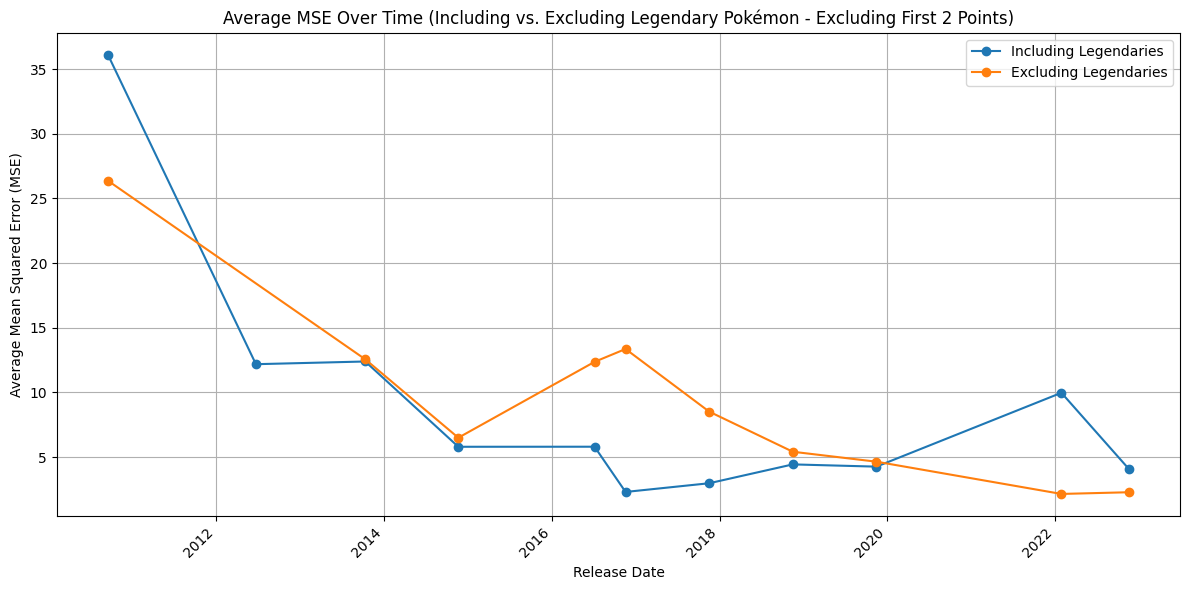

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure df_mse_by_prediction_step and df_mse_by_prediction_step_non_legendary are available
if 'df_mse_by_prediction_step' in locals() and 'df_mse_by_prediction_step_non_legendary' in locals():

    # Calculate the average MSE across all metrics for each prediction step (release date)
    average_mse_over_time_legendary = df_mse_by_prediction_step.mean(axis=0)
    average_mse_over_time_non_legendary = df_mse_by_prediction_step_non_legendary.mean(axis=0)

    # Convert the index to datetime objects for plotting
    average_mse_over_time_legendary.index = pd.to_datetime(average_mse_over_time_legendary.index)
    average_mse_over_time_non_legendary.index = pd.to_datetime(average_mse_over_time_non_legendary.index)

    # Exclude the first 2 data points for plotting
    average_mse_over_time_legendary_sliced = average_mse_over_time_legendary.iloc[2:]
    average_mse_over_time_non_legendary_sliced = average_mse_over_time_non_legendary.iloc[2:]


    # Plot the average MSE over time
    plt.figure(figsize=(12, 6))

    plt.plot(average_mse_over_time_legendary_sliced.index, average_mse_over_time_legendary_sliced.values, marker='o', linestyle='-', label='Including Legendaries')
    plt.plot(average_mse_over_time_non_legendary_sliced.index, average_mse_over_time_non_legendary_sliced.values, marker='o', linestyle='-', label='Excluding Legendaries')

    plt.title('Average MSE Over Time (Including vs. Excluding Legendary Pokémon - Excluding First 2 Points)')
    plt.xlabel('Release Date')
    plt.ylabel('Average Mean Squared Error (MSE)')
    plt.grid(True)
    plt.legend()

    # Improve date formatting on the x-axis
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

else:
    print("Error: MSE dataframes not found. Please run the model evaluation cells first.")

### Conclusion 5: Legendaries: Lore vs. Meta Influence?

Our analysis comparing forecasting models with and without Legendary and Mythical Pokémon suggests that including these powerful Pokemons actually results in a slightly lower average MSE (Mean Squared Error). This indicates that, for our model, the historical data *including* Legendaries provides a slightly better fit for forecasting the overall trends in aggregated Pokémon type statistics over time.

While Legendary Pokémon undoubtedly hold significant lore importance, these results imply that their statistical profiles and the trends associated with their introduction are also part of the broader game design patterns that influence the statistical evolution of Pokémon types. This suggests that game balance considerations, even those impacting the competitive meta, might encompass the entire roster of Pokémon, including Legendaries, rather than being solely focused on non-legendary species.

### Limitations and Future Work

It's important to acknowledge the limitations of the current analysis. Our models focused on aggregated type statistics and type vulnerabilities based on standard matchups. However, several crucial factors in Pokémon battles were not included:

*   **Abilities and Hidden Abilities:** These can significantly alter a Pokémon's performance and type interactions in ways not captured by raw stats or basic type effectiveness.
*   **Specific Attacks and Movepools:** The actual moves a Pokémon can learn, their power, type, and additional effects play a vital role in its viability and how it contributes to the meta.

Therefore, future work could involve:

*   **Quantifying Abilities:** Researching methods to assign a numerical value or impact score to different abilities to incorporate their influence into the analysis.
*   **Incorporating Move Data:** Including data on Pokémon movepools and attack power to create more nuanced metrics of offensive and defensive potential.
*   **Refining Prediction Models:** Exploring more complex time series models or machine learning techniques that can better capture the intricate dynamics of the Pokémon meta.
*   **Illustrating Results with Generative AI:** Using tools like the Gemini API to creatively illustrate the model's predictions – for example, generating descriptions or even visual concepts for hypothetical Pokémon that embody the predicted statistical shifts or exploring scenarios based on potential meta changes.

Adding these elements would provide a more comprehensive understanding of Pokémon type strength and the evolution of the competitive landscape over time.